In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.append('./release')

In [5]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [7]:
use_cuda = torch.cuda.is_available()

In [8]:
use_cuda

True

In [9]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
gen_data_path = 'data/chembl_22_clean_1576904_sorted_std_final.smi'

In [12]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [13]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [14]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted PCE', 
           title='Distribution of predicted PCE for generated molecules')
    plt.show()

In [15]:
def estimate_and_update(generator, predictor, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction


In [16]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

In [17]:
model_path = './check/generator/checkpoint_biggest_rnn'

In [ ]:
losses = my_generator.fit(gen_data, 15000)

In [ ]:
plt.plot(losses)

In [17]:
my_generator.evaluate(gen_data)

./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


'<3i=5+\\%)@0-I9\\30<.<3>'

In [18]:
my_generator.save_model(model_path)

In [18]:
my_generator.load_model(model_path)

In [19]:
sys.path.append('./OpenChem/')

In [21]:
from rnn_predictor import RNNPredictor

In [22]:
predictor_tokens = tokens + [' ']

In [28]:
path_to_params = './check/cepv2/model_parameters1.pkl'
path_to_checkpoint = './check/cepv2/fold_'

In [ ]:
my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, predictor_tokens)

In [ ]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

In [ ]:
from reinforcement import Reinforcement

In [ ]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [ ]:
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 60

In [ ]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

In [ ]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    mol, prop, nan_smiles = predictor.predict([smiles])
    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] >= 1.0) and (prop[0] <= 4.0):
        return 11.0
    else:
        return 1.0

In [ ]:
x = np.linspace(-5, 12)
reward = lambda x: 11.0 if ((x > 1.0) and (x < 4.0)) else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('PCE value')
plt.ylabel('Reward value')
plt.title('Reward function for PCE optimization')
plt.show()

In [73]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [74]:
rewards = []
rl_losses = []



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Policy gradient...:   7%|▋         | 1/15 [00:01<00:21,  1.54s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:03<00:19,  1.53s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:17,  1.45s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:16,  1.50s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:07<00:15,  1.51s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.42s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:10<00:11,  1.42s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.39s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.43s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.47s/it]

Po

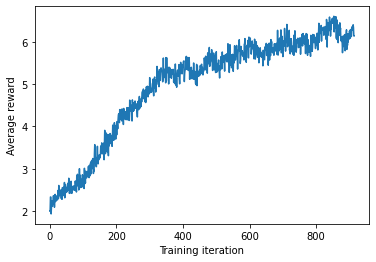

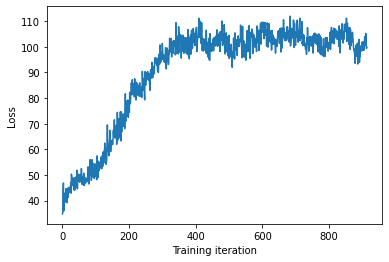



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.41it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.41it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.41it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.41it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.84it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.84it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.84it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.84it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.84it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 27.44it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9333333333333333
Proportion of valid SMILES: 0.825


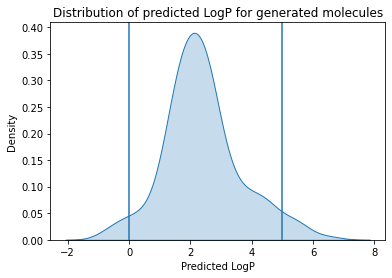



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C(C)COC1=C(O)C(=O)c2ccccc2C1=O                                                           
C=CCN1nC(c2cccnc2OC)Coc1S(=O)(=O)c1ccccc1-c1nnnn1Cc1ccccc1                                 
CC(=NNc1ccccc1)c1cnnn1                                                                     
CC(=O)Nc1ncnc2c1C=Cc1cn(cn1)c1ccccc21                                                      
CC(=O)Nc1nsc(-c2ccncc2)n1                                                                  




Policy gradient...:   7%|▋         | 1/15 [00:01<00:20,  1.50s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:18,  1.42s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.38s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.38s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:14,  1.44s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.39s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:11,  1.42s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.38s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.40s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.40s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.44s/it]

Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.38s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.34s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.39s/it]

Policy gradient...: 100%|██████████| 15/1

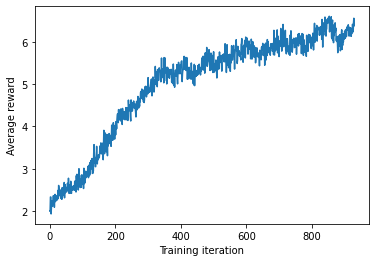

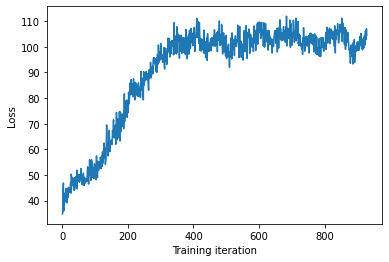



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:15, 12.64it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:15, 12.64it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:15, 12.64it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:15, 12.64it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:13, 14.85it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:13, 14.85it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:13, 14.85it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:13, 14.85it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:13, 14.85it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:10, 17.70it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:10, 17.70it/s]

Generating 

Percentage of predictions within drug-like region: 0.9820359281437125
Proportion of valid SMILES: 0.835


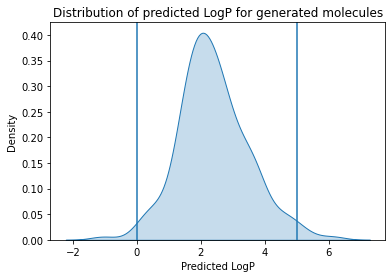



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)(COc1ccccc1)Nc1ncnc2cc(C(F)(F)F)ccc12                                      
CC(=O)C(c1ccco1)c1nnn(-c2ccccn2)c1-c1ccccc1                                      
CC(=O)Nc1ccccc1Sc1ccc(S(=O)(=O)Nc2ncnc3ccccc23)cc1                               
CC(=O)c1cccns1                                                                   
CC(C(=O)OCC(=O)c1cccnc1)c1nccnc1Sc1ncnc2ccccc12                                  




Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.39s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:03<00:19,  1.47s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:17,  1.44s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.42s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:07<00:14,  1.41s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:13,  1.46s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:10<00:11,  1.42s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:10,  1.43s/it]

Policy gradient...:  60%|██████    | 9/15 [00:13<00:08,  1.47s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.44s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:16<00:05,  1.48s/it]

Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.42s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.44s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:20<00:01,  1.37s/it]

Policy gradient...: 100%|██████████| 15/1

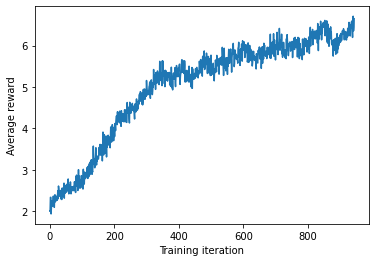

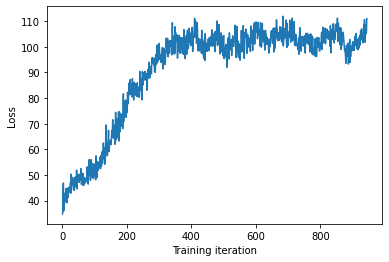



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:11, 17.16it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:11, 17.16it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:11, 17.16it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:11, 16.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:11, 16.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:11, 16.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:11, 16.92it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:10, 18.79it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:10, 18.79it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:10, 18.79it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.9485714285714286
Proportion of valid SMILES: 0.875


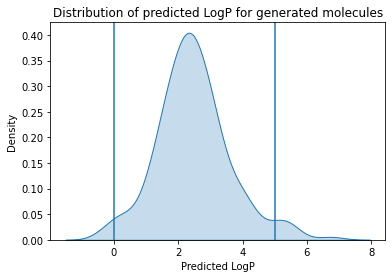



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C(C)Cc1cc2ccccc2nc1S(=O)(=O)c1ccc(N(=O)=O)cc1                                                    
CC(=O)Nc1ccc(-c2nnnn2Cc2ccccc2)cc1                                                                 
CC(=O)n1cc(-c2cn(C3CCC(n4ncnn4)CC3)nn2)cn1                                                         
CC(=O)n1ccnc1C(=O)c1cccnc1                                                                         
CC(C)(C)c1nc(-c2ccccn2)nc(-c2cn(C(=O)Nc3ccccc3)cn2)n1                                              




Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.38s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.35s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:15,  1.31s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.41s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.35s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.39s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:11,  1.42s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:10,  1.45s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.45s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.47s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:06,  1.50s/it]

Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.45s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.44s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.41s/it]

Policy gradient...: 100%|██████████| 15/1

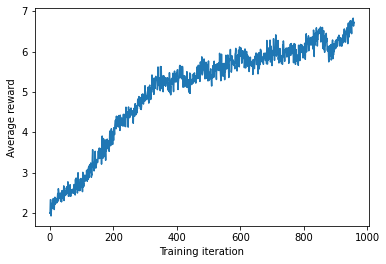

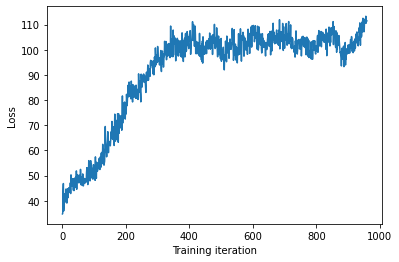



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 26.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 26.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 26.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 26.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 26.87it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 28.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 28.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 28.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 28.34it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9595375722543352
Proportion of valid SMILES: 0.865


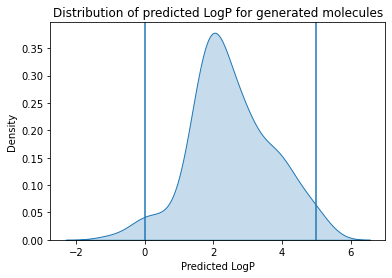



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)N(c1cccc(C(=O)O)c1)c1cnnc(-c2ccncc2)n1                                            
CC(=O)Nc1cc(c2ncnc(-c3ccccc3)n2)ccc1NC(=O)Nc1cccnc1                                     
CC(=O)Nc1ncncc1-c1nccnc1C1CCN(Cc2ccncc2)CC1                                             
CC(C)Nc1ncnc2cnccc12-c1ccc(-c2nnccc2F)n1                                                
CC(C)c1nSnc(SCc2ncncn2)nn1                                                              




Policy gradient...:   7%|▋         | 1/15 [00:01<00:18,  1.30s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:18,  1.39s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:17,  1.45s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.40s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:07<00:13,  1.37s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.39s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.34s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.35s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.41s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.40s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.38s/it]

Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.36s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.33s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.35s/it]

Policy gradient...: 100%|██████████| 15/1

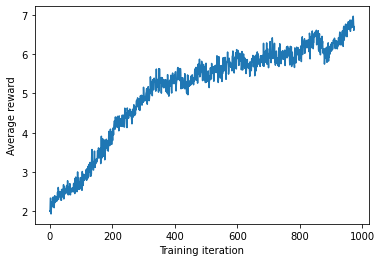

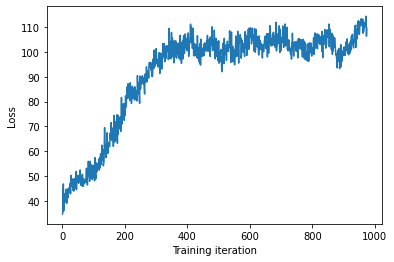



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.56it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.56it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.56it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.56it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.67it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.67it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 25.67it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:08, 22.03it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:08, 22.03it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:08, 22.03it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.949438202247191
Proportion of valid SMILES: 0.89


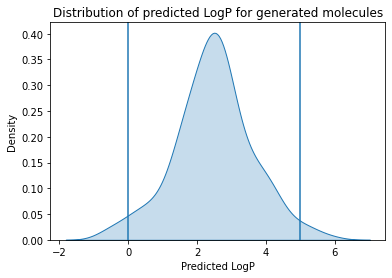



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C#C1NC(=O)c2cnc(Sc3cn(C)nn3)cc2N=C1c1ccc(NC(=O)c2ccccc2OC)cc1                                                        
C#c1ccccc1C(O)n1nncc1-c1ccccc1OC                                                                                     
CC(=O)OCCC(NC(c1ccncc1)C1CC1=O)c1cc(-c2ccncc2)ncn1                                                                   
CC(=O)Oc1ccccc1-c1ncncn1                                                                                             
CC(C)CC(C#N)(c1ccccc1)c1ncncn1                                                                                       


./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.28s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.31s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:15,  1.33s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.40s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.38s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.38s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.36s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.34s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.36s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.39s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.40

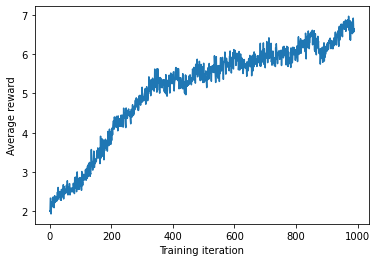

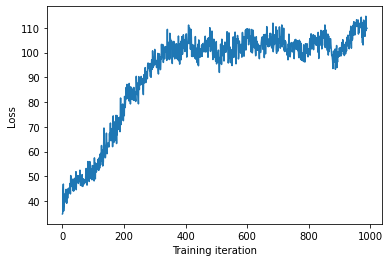



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:10, 19.30it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:10, 19.30it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:10, 19.30it/s]

Generating molecules...:   1%|          | 2/200 [00:00<00:10, 19.30it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:09, 21.11it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:09, 21.11it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:09, 21.11it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:09, 21.11it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:09, 21.11it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:07, 24.00it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:07, 24.00it/s]

Generating 

Percentage of predictions within drug-like region: 0.9529411764705882
Proportion of valid SMILES: 0.85


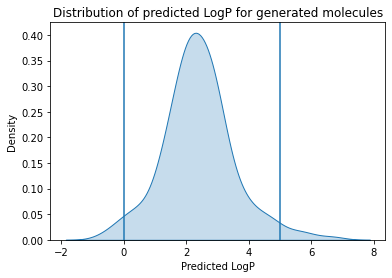



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)CN1c2nc(ccc2Nc2ccccc2)n1-c1ccccc1                                                
CC(=O)N(CC1CCCO1)c1ncnc2c1ncn2-c1ccc(-c2ccccc2)nn1                                     
CC(=O)NC(CC1CN(Cc2nccn2-c2ccccc2)CCO1)c1ccc(-c2ncnn2C)cc1                              
CC(=O)Nc1ccc(-c2nnn(S(=O)(=O)c3ccccc3)c2-c2nc(C)ccc2-c2nccn2C)cn1                      
CC(=O)Nc1ccc(Cn2nnc3ccccc32)cn1                                                        




Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.25s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.26s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.35s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.41s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:07<00:15,  1.53s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:13,  1.52s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:10<00:11,  1.47s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.42s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.37s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.46s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.45s/it]

Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.41s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.40s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:20<00:01,  1.41s/it]

Policy gradient...: 100%|██████████| 15/1

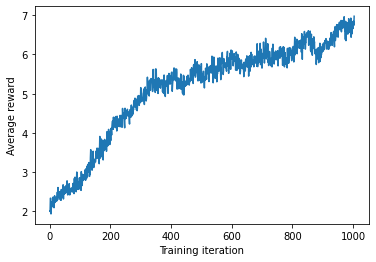

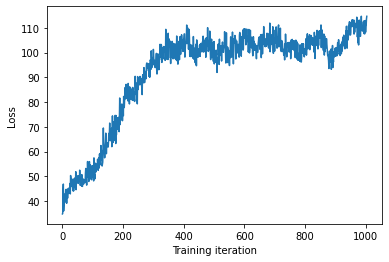



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 24.67it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 24.67it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 24.67it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.49it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:07, 24.36it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:07, 24.36it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.9771428571428571
Proportion of valid SMILES: 0.875


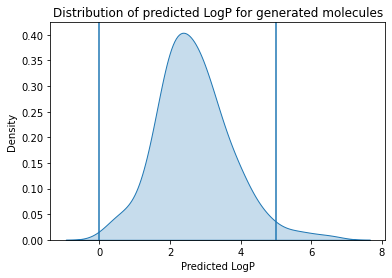



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C(Nc1ncnc2c1cnn2Cc1ccccc1)C(CC)c1cccc(C)c1                                        
CC(=O)Nc1ncnc(N(=O)=O)Sc2nnc(C3CCCCC3)n2c2c(C)cccc12                                
CC(=O)c1ccc(-c2nnc(SCc3nc(-c4ccco4)cn3-c3ccccc3)s2)cc1                              
CC(=O)c1ccccn1                                                                      
CC(C)NS(=O)(=O)c1ccc(S(=O)(=O)N2C=CC(CC(O)(O)CO)CC2)cn1                             




Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.28s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.37s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.38s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.42s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:07<00:13,  1.38s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.41s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:11,  1.39s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.36s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.43s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.45s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.44s/it]

Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.47s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.47s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.39s/it]

Policy gradient...: 100%|██████████| 15/1

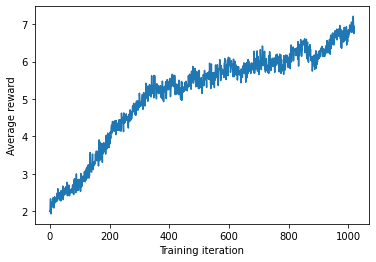

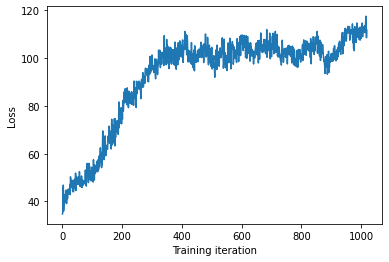



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.56it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.56it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.56it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.56it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.85it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.85it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.85it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.85it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:06, 28.32it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:06, 28.32it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.9485714285714286
Proportion of valid SMILES: 0.875


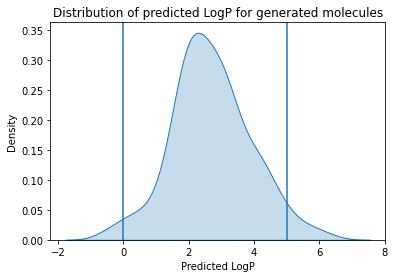



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                                     
C=CCOC1COCC1c1ncnc(N(C)Cc2cccnc2Cl)n1                                                 
C=Cc1cnn(-c2ccccn2)c1C(=O)Nc1ccc(S(=O)(=O)N2CCCCC2)cc1                                
CC(=NNc1ncnc(-c2ccccc2)n1)c1nnc2snccn12                                               
CC(=O)Nc1ncccc1-c1ncccc1-n1cnc2cnccc21                                                




Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.40s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:18,  1.40s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.39s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.38s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.37s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.41s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:11,  1.41s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:10,  1.46s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.49s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:06,  1.39s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.36s/it]

Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.45s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.48s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.45s/it]

Policy gradient...: 100%|██████████| 15/1

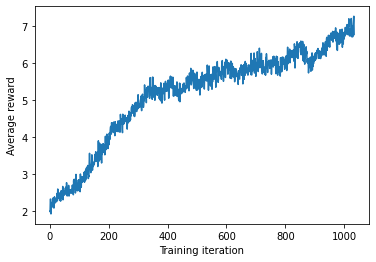

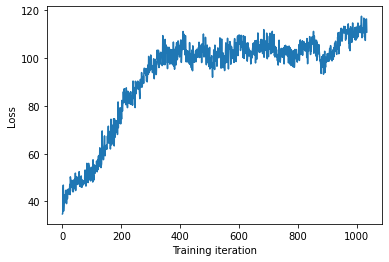



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 22.27it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 22.27it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 22.27it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 22.27it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:08, 23.87it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:08, 23.87it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:08, 23.87it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:08, 23.87it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:07, 24.63it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:07, 24.63it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.9171597633136095
Proportion of valid SMILES: 0.845


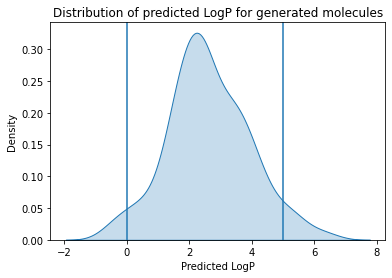



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C1Nc2cnc1c(BrC)nccc1cc2c2ccccc12                                             
C=CC1CCCCN1NC1=NN=C(Sc2ccccc2C(C)=O)c2ccccc2N=C1                               
C=CCn1ccnc1-c1nnnc(-c2ccc(N(=O)=O)cc2)c2ncccc2OCn2ccnc2-1                      
CC(=O)N(N=Cc1ncnc(-c2ccccc2)n1)c1nccc(-c2cccnc2)n1                             
CC(=O)Oc1ccccc1                                                                




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.20s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.29s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:15,  1.31s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.36s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:07<00:14,  1.43s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:13,  1.52s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:10<00:11,  1.45s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:10,  1.51s/it]

Policy gradient...:  60%|██████    | 9/15 [00:13<00:08,  1.47s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.41s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.37s/it]

Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.46s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.41s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:20<00:01,  1.43s/it]

Policy gradient...: 100%|██████████| 15/1

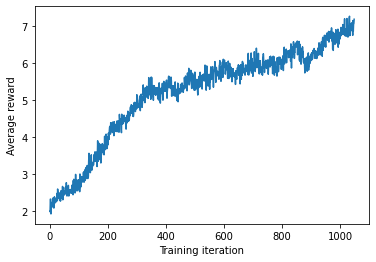

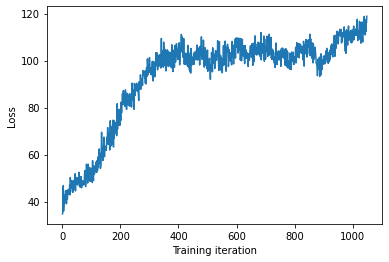



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 24.32it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 24.32it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 24.32it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.67it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.67it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.67it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:08, 22.67it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:08, 22.06it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:08, 22.06it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:08, 22.06it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.8994413407821229
Proportion of valid SMILES: 0.895


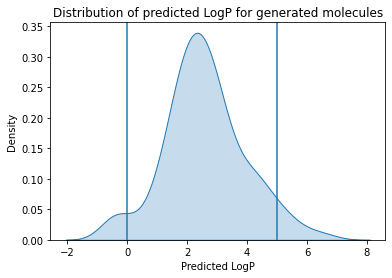



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                                  
C=CNCc1nc2ncnc(Oc3ccnc(OCC)n3C)c2n1                                                
CC(=O)Nc1ccnnc1-c1ncnc(N2CCOCC2)n1                                                 
CC(=O)c1ccccc1CNC(=O)Oc1ncccc1-c1nccn1C                                            
CC(=O)c1nccn1C(c1ccccc1)c1cccc(-c2nnc(-c3ncccc3-c3nccs3)n2C2CCCCCC2)c1             




Policy gradient...:   7%|▋         | 1/15 [00:01<00:21,  1.52s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:19,  1.47s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:17,  1.48s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.43s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:07<00:14,  1.43s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.44s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:11,  1.42s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.37s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.37s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.29s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.28s/it]

Policy gradient...:  80%|████████  | 12/15 [00:16<00:03,  1.29s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.35s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.38s/it]

Policy gradient...: 100%|██████████| 15/1

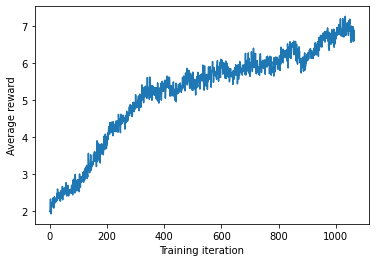

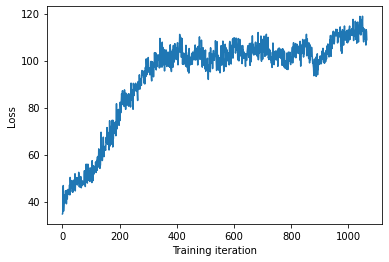



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 25.70it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 25.70it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 25.70it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 25.70it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 25.70it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:07, 26.31it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:07, 26.31it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:07, 26.31it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:07, 26.31it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9508196721311475
Proportion of valid SMILES: 0.915


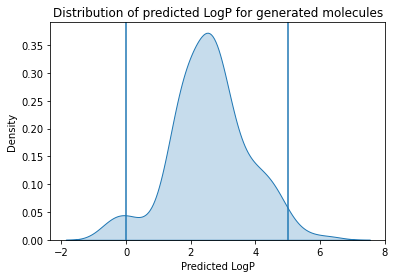



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=Cc1cc(-c2cnn3nc(Oc4ncccc4-c4nccc(C)n4)cc23)c(OC)cc1-c1cnnn1                                         
CC(=O)N(C)c1nnc(-c2cccc(Cl)c2c2ncnn2)c2ccccn12                                                        
CC(=O)Nc1cc(N(C2C=Nc3ccccc3C2)n2cnnn2)ccc1N1CCCC1                                                     
CC(=O)Nc1ncc(-c2ccnn2Cc2ccccc2-c2ccccc2)nc1-c1cnnc1                                                   
CC(=O)c1ccccc1-c1nc(-c2ccco2)cn1-c1cn(-c2ccccc2)nc1-c1ccccc1                                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.25s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.24s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.25s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.29s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:14,  1.41s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.43s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.36s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:11<00:09,  1.42s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.48s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:14<00:07,  1.47s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.47s/it]

Policy gradient...:  80%|████████  | 12/15 [00:17<00:04,  1.48s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:18<00:02,  1.46s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:20<00:01,  1.48s/it]

Policy gradient...: 100%|██████████| 15/1

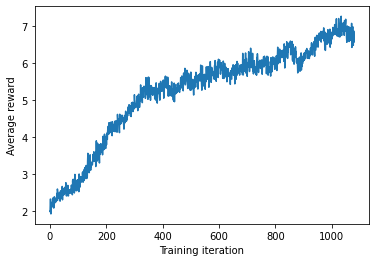

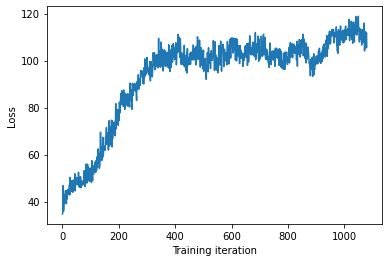



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.38it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.38it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.38it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.38it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 27.68it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9086021505376344
Proportion of valid SMILES: 0.93


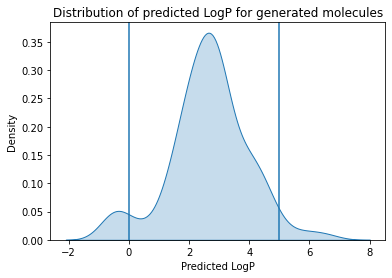



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                                                
C=CCCc1nnc(S(=O)(=O)c2cccc(C)c2)nc1C#Cc1ccncc1                                                   
C=Cc1c(-c2csc(C(=O)N3CCN(c4ccccc4OC)CC3)c2nc2ccccc2N(=O)=O)ccc2ncccc12                           
CC(=O)Nc1ncnn2c(CNc3ccc(F)cn3)ncc12                                                              
CC(=O)Nc1nnc(c2cc(-c3ccc(S(=O)(=O)N4CCCCC4)cc3)nn2)nc1C                                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.14s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:15,  1.18s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.23s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:13,  1.23s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.30s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.33s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.34s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.32s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:08,  1.34s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.32s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.33s/it]

Policy gradient...:  80%|████████  | 12/15 [00:15<00:04,  1.35s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.39s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:18<00:01,  1.36s/it]

Policy gradient...: 100%|██████████| 15/1

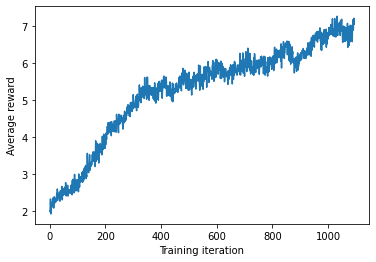

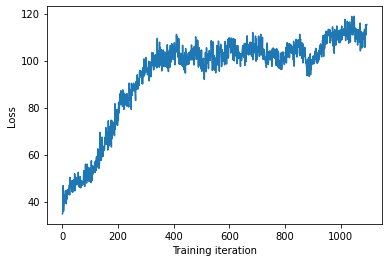



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.57it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.57it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.57it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.57it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.57it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.48it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.48it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.48it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.48it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 27.58it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9421965317919075
Proportion of valid SMILES: 0.865


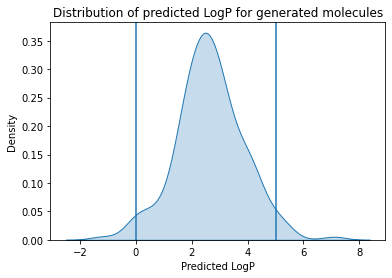



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1ccc2nc(-c3nccnc3-c3ncccn3)sc2c1                                             
CC(=O)Nc1ccccc1C(=O)N1CNc2ncncc2C1                                                   
CC(=O)Nc1ncnnc1Cc1ccc(-n2ccnc2)cn1                                                   
CC(=O)c1ccc(S(=O)(=O)Nc2ccc3c(n2)-c2ccc(Cl)cc2C(=O)N3)cc1                            
CC(C)c1nccc2c(N3CCN(c4ncccc4Cl)CC3)ncnc12                                            




Policy gradient...:   7%|▋         | 1/15 [00:01<00:20,  1.47s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:18,  1.39s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:16,  1.37s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.27s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.30s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:12,  1.36s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.34s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.38s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:08,  1.34s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.36s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.37s/it]

Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.41s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.40s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:18<00:01,  1.39s/it]

Policy gradient...: 100%|██████████| 15/1

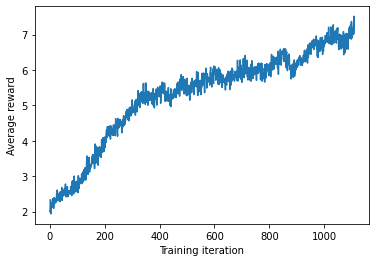

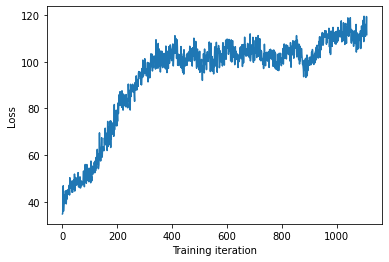



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.40it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.40it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.40it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.40it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 28.39it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9497206703910615
Proportion of valid SMILES: 0.895


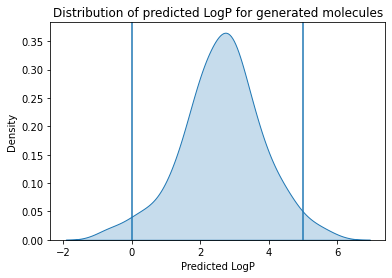



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                                                                 
CC(=NN1CCN(Cc2ccncc2)c2ccccc2C1)c1ccncc1                                                                          
CC(=NNc1ncnnc1C)c1ccnc(-c2ccncn2)c1                                                                               
CC(=O)Nc1ccccc1C(Nc1ncncn1)n1ccnc1                                                                                
CC(=O)Nc1nc(-c2nccnn2)cn#1                                                                                        




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.20s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.26s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:15,  1.30s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.32s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.27s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.24s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:08,  1.27s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.28s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.27s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.28s/it]

Policy gradient...:  80%|████████  | 12/15 [00:15<00:03,  1.30s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:16<00:02,  1.23s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:17<00:01,  1.27s/it]

Policy gradient...: 100%|██████████| 15/1

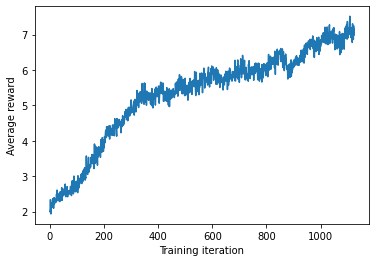

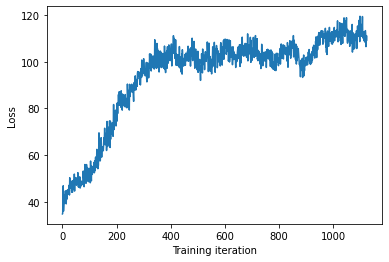



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.52it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.52it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.52it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.52it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.32it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.32it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.32it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.32it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.32it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9712643678160919
Proportion of valid SMILES: 0.87


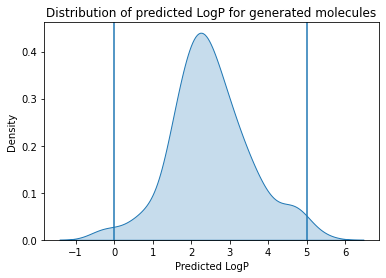



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCN(c1ccc(OC(=O)c2cccnc2)cc1)C(c1ccc(Nc2ncnnc2C(=O)NCCCC)cc1)c1cnn(Cc2ccccn2)n1         
C=Cc1cccc(-c2cnnnc2-c2ccc(-c3cncnc3)cc2)c1                                                
CC(=O)C=Cc1ccccc1-c1ncnn1-c1ccccc1                                                        
CC(=O)Nc1ccccc1CNC(=O)Nc1cnnc(-c2ncccn2)n1                                                
CC(=O)Oc1cccc(-c2ccccc2)C=CC(=O)Nc2cnc3cccnn3c2n1                                         




Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.36s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.33s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:16,  1.34s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.31s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.30s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.38s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.34s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.30s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.29s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.37s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.34s/it]

Policy gradient...:  80%|████████  | 12/15 [00:15<00:03,  1.30s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.28s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:18<00:01,  1.25s/it]

Policy gradient...: 100%|██████████| 15/1

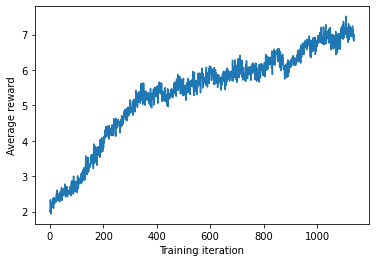

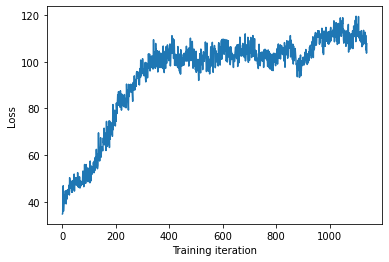



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 28.10it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 28.10it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 28.10it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 28.10it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 28.10it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.93it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.93it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.93it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.93it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:07, 26.88it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9550561797752809
Proportion of valid SMILES: 0.89


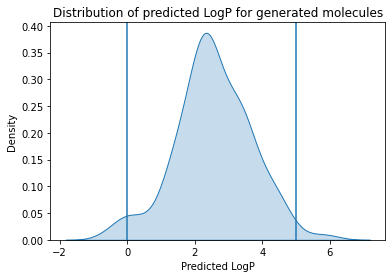



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCN(c1cc2c(cn1)CC(c1cccnc1)CN2)C1nnN(C)C1=O                                          
CC(=O)Nc1cncc(-c2ncnn2Oc2ncncc2Cl)n1                                                   
CC(=O)c1cnccc1Oc1nncnc1Nc1cccnc1                                                       
CC(=O)c1cnnn1-c1cnccc1Nc1cccc(S(N)(=O)=O)c1                                            
CC(C)(C)c1nc[nH]c1N(=O)=S                                                              




Policy gradient...:   7%|▋         | 1/15 [00:01<00:18,  1.29s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.28s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:15,  1.28s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.30s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.30s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.25s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.30s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.29s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.30s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.30s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.35s/it]

Policy gradient...:  80%|████████  | 12/15 [00:15<00:04,  1.33s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.42s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:18<00:01,  1.34s/it]

Policy gradient...: 100%|██████████| 15/1

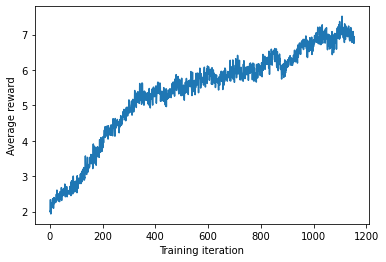

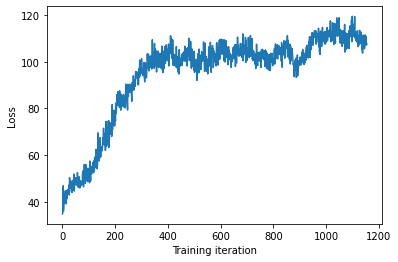



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 29.07it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.96it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.96it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.96it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.96it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 27.94it/s]

Generating molecules...:  

Percentage of predictions within drug-like region: 0.9761904761904762
Proportion of valid SMILES: 0.84


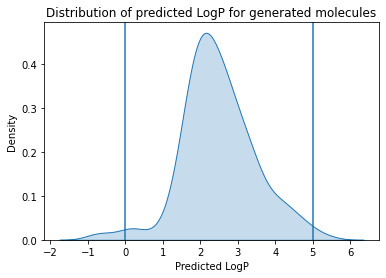



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C#CCC(Nc1cccnc1)c1nnc(C(=O)CCCNC(=O)c2cc3ccccc3cn2-c2ccncc2)n1Cc1ccccc1    
C=CCn1ncnc1-c1cccc(-c2ccnc(NO)n2)c1                                        
C=Cn1nccc1-c1cnnc(-c2ccc(OC)cc2)n1                                         
CC(=Nc1ncsc1Cc1ccc(-c2ccncc2)cc1)c1ncccn1                                  
CC(=O)c1cccc(-c2cnn(C3NC(=O)CN=C3c3ccc4ccccc4c3)c2)c1                      




Policy gradient...:   7%|▋         | 1/15 [00:01<00:23,  1.67s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:03<00:20,  1.58s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:18,  1.50s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.42s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.38s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.37s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.32s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.30s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:07,  1.33s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.34s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.33s/it]

Policy gradient...:  80%|████████  | 12/15 [00:16<00:03,  1.33s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.30s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:18<00:01,  1.27s/it]

Policy gradient...: 100%|██████████| 15/1

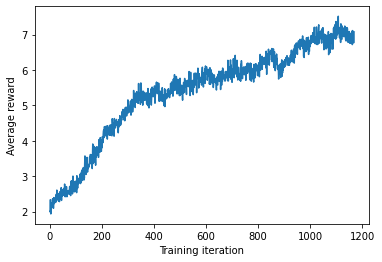

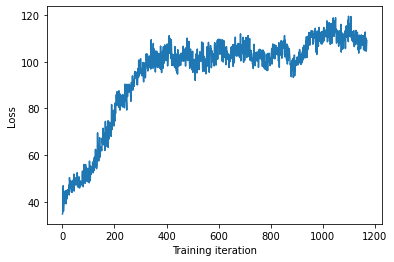



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 25.19it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 25.19it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 25.19it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 25.19it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 26.44it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 26.44it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 26.44it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 26.44it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 26.44it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:07, 27.04it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9441340782122905
Proportion of valid SMILES: 0.895


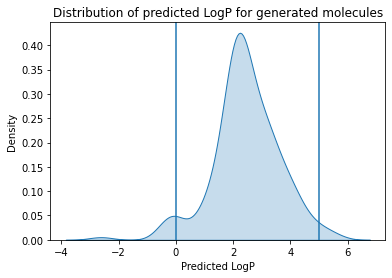



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=Cc1cccnc1-c1ncnn2c1nc1cccnn12                                                            
CC(=O)Nc1cccc(-c2ncn3ncnc(-c4ccncc4)c23)c1                                                 
CC(=O)Nc1ccccc1-c1nnc(Nc2ccc3ccccc3c2O)on1                                                 
CC(=O)c1cccc(NC(=O)c2ccc(S(=O)(=O)c3ccccc3)cc2)nc1                                         
CC(=O)c1ccccc1NC(=O)c1cc2ncnn2c(N2CCC(C)(C)CC2)n1                                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.29s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.31s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.25s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.34s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:13,  1.35s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.36s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.37s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.31s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:08,  1.37s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.38s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:15<00:05,  1.41s/it]

Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.35s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.39s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:19<00:01,  1.40s/it]

Policy gradient...: 100%|██████████| 15/1

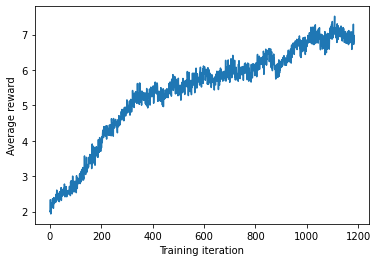

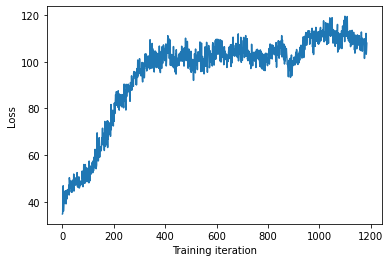



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.26it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.26it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.26it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.26it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.26it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.59it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.59it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.59it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.59it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9195402298850575
Proportion of valid SMILES: 0.87


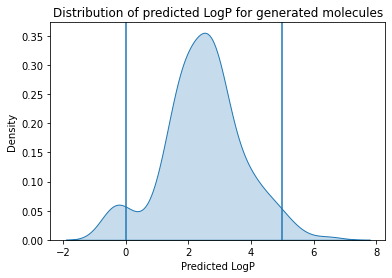



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCNc1nccnc1C(=O)Nc1ccc(-c2ccnnc2)nc1                                           
C=CCc1nccnc1N(c1nccnn1)c1ccccc1OC                                                
CC(=O)(NC(=O)c1cnnn1Cc1ccccc1)c1nccnc1-c1ncnn1Cc1ccccc1                          
CC(=O)N1C=c2c(ncnc2CN2CCOCC2)CC1                                                 
CC(=O)Nc1ccccc1C(=O)NCCCNc1ncccc1-c1ncnc(-c2ccncc2)n1                            




Policy gradient...:   7%|▋         | 1/15 [00:01<00:21,  1.54s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:19,  1.49s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.39s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:15,  1.37s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:14,  1.41s/it]

Policy gradient...:  40%|████      | 6/15 [00:08<00:12,  1.40s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:09<00:10,  1.32s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:09,  1.35s/it]

Policy gradient...:  60%|██████    | 9/15 [00:12<00:07,  1.32s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:13<00:06,  1.30s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:14<00:05,  1.33s/it]

Policy gradient...:  80%|████████  | 12/15 [00:16<00:04,  1.36s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:17<00:02,  1.32s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:18<00:01,  1.32s/it]

Policy gradient...: 100%|██████████| 15/1

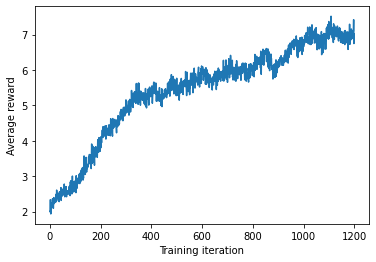

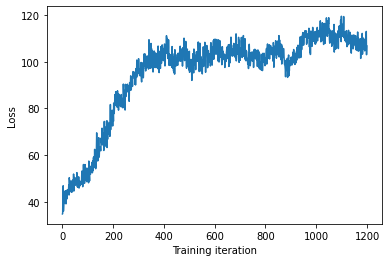



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.50it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.50it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.50it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.50it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.50it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 32.32it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 32.32it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 32.32it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 32.32it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9542857142857143
Proportion of valid SMILES: 0.875


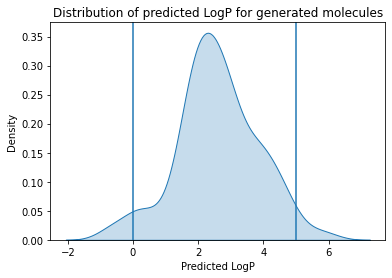



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCN(C(=O)Oc1cnnc(-c2ccccn2)c1)c1ccncc1                                         
CC(=O)Nc1ccccc1-c1sc2ncnc(COC3CCN(C)CC3)nc2c1-c1ccccn1                           
CC(=O)Nc1nnc(-c2cncnc2-c2nc3ccccc3OCCc3ccccc32)s1                                
CC(=O)c1ccccc1Nc1ccnc(Nc2ncnc3nsnc23)n1                                          
CC(C(=O)Nc1ccncn1)c1nnnn1-c1cccN2CCOc2c1                                         




Policy gradient...:   7%|▋         | 1/15 [00:01<00:20,  1.47s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:18,  1.39s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:16,  1.35s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.35s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.24s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.18s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:08,  1.28s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.30s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.23s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:05,  1.26s/it]

Policy gradient...:  80%|████████  | 12/15 [00:15<00:03,  1.25s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:16<00:02,  1.20s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:17<00:01,  1.19s/it]

Policy gradient...: 100%|██████████| 15/1

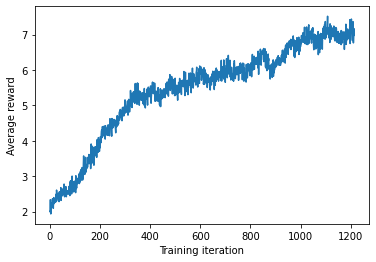

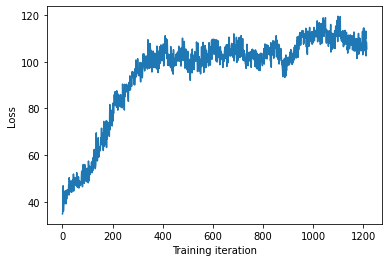



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 23.70it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 23.70it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 23.70it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 23.70it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:08, 23.70it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 25.16it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 25.16it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 25.16it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 25.16it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:07, 25.01it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9488636363636364
Proportion of valid SMILES: 0.88


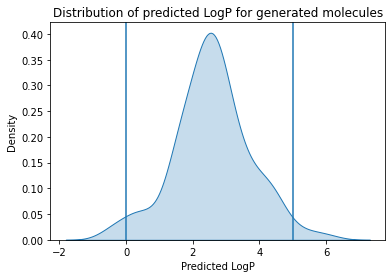



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCNc1cccc(C)c(S(=O)(=O)c2ccc(-c3nncn3-c3ccccc3)cc2)n1                                
CC(=Cc1ccncc1)Cc1nncn1-c1ccScn1                                                        
CC(=NNc1cc(c2cnn(-c3ccncc3)c2)ccc1-c1ccncc1)S(=O)(=O)c1cccnc1                          
CC(=O)Nc1ccccc1Nc1ncnc2nc(-c3ccncc3)nn12                                               
CC(=O)c1ccccc1NC(=O)N1C(CCc2ccncc2)CN2CC(CO)CC1C2                                      




Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.23s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.26s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:15,  1.27s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:13,  1.24s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.23s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.26s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.24s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:08,  1.27s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.29s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.26s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:05,  1.28s/it]

Policy gradient...:  80%|████████  | 12/15 [00:15<00:03,  1.32s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:16<00:02,  1.28s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:17<00:01,  1.26s/it]

Policy gradient...: 100%|██████████| 15/1

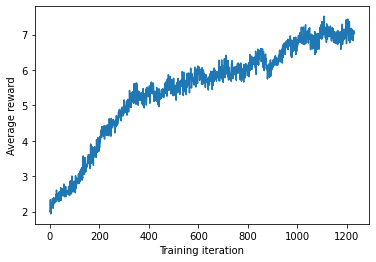

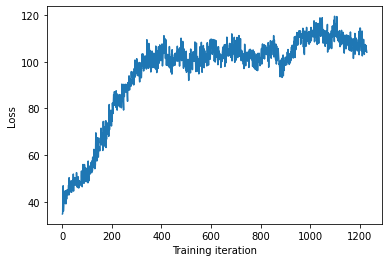



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.71it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.71it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.71it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.71it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 27.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 27.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 27.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 27.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:07, 27.23it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 28.12it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9725274725274725
Proportion of valid SMILES: 0.91


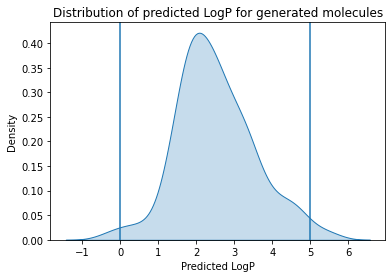



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=NNc1nccc2nc(-c3cccnc3)ncc12                                                          
CC(=NCc1ccccn1)c1ncnc(-n2nccn2)n1                                                      
CC(=O)CSc1nnc(C2Cc3ccccc3C2)s1                                                         
CC(=O)NC1c2ccccc2C(CO)ON(CC(=O)c2cncnc2)C2CCCC2N2OC1C2O                                
CC(=O)NN=C(Nc1nnnn1C(=O)c1ccccc1)c1ccccc1-c1cnnn2cccc12                                




Policy gradient...:   7%|▋         | 1/15 [00:01<00:18,  1.33s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.35s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:15,  1.31s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:13,  1.27s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.20s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.20s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.20s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.17s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.27s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.25s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:05,  1.25s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.25s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.20s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:17<00:01,  1.23s/it]

Policy gradient...: 100%|██████████| 15/1

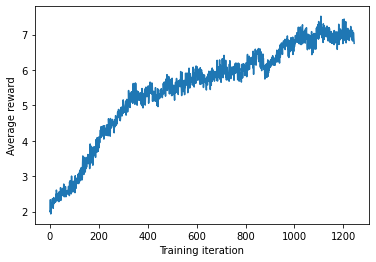

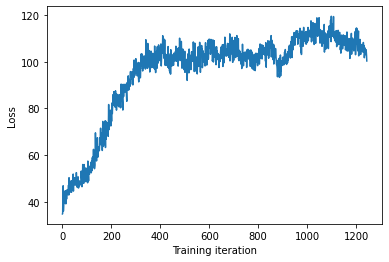



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.55it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.55it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.55it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.55it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   3%|▎         | 6/200 [00:00<00:06, 28.23it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 29.35it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9782608695652174
Proportion of valid SMILES: 0.92


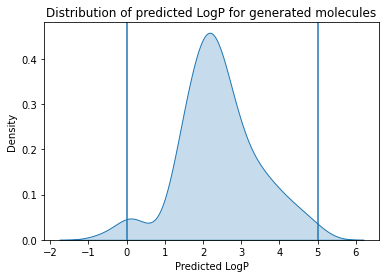



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=NNC(=O)Nc1ccccn1)c1ccc(N2CCCCC2)cc1                                           
CC(=NNC(=O)c1ccccc1F)c1cnnnc1-c1ccccc1                                            
CC(=O)Nc1cccc(-c2cnnc2SCCC(=O)c2ccccc2)c1                                         
CC(=O)Nc1cccc(N2CCN(Cc3ccnn3n3ccnc3)c2-c2ccnnc2-c2ccccn2)c1                       
CC(=O)Nc1ccnnc1-c1cncnc1                                                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.40s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.31s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:15,  1.32s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.31s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.28s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.27s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:10,  1.26s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:10<00:08,  1.26s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.25s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.25s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:05,  1.25s/it]

Policy gradient...:  80%|████████  | 12/15 [00:15<00:03,  1.26s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:16<00:02,  1.21s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:17<00:01,  1.22s/it]

Policy gradient...: 100%|██████████| 15/1

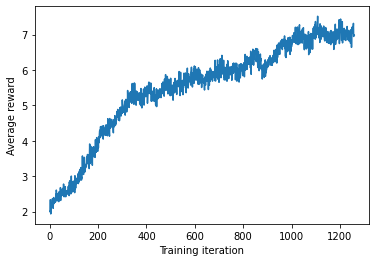

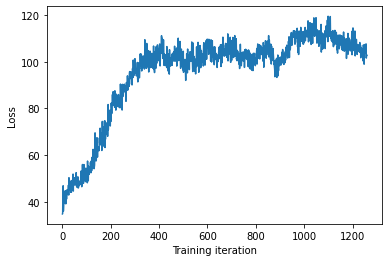



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 27.76it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 27.76it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 27.76it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:07, 27.76it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 27.09it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 27.09it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 27.09it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 27.09it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:07, 27.09it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9606741573033708
Proportion of valid SMILES: 0.89


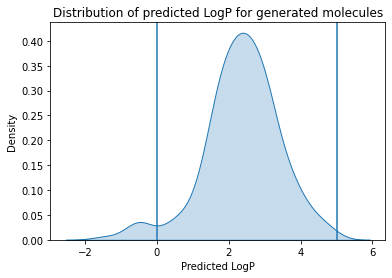



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CC(=O)Nc1nnnc(-c2cncnc2)n1                                                  
C=Cc1cc(C(c2c(nc3cccnc3)nc3ccccc3N2)c2ccccc2O)c(-c2cnccn2)cn1                 
CC(=NNc1ccccc1)(c1ccccn1)c1ncnn1-c1ccccc1                                     
CC(=O)NC(c1ccccn1)c1ncncc1S(=O)(=O)c1ccccc1                                   
CC(=O)Nc1nc(-c2cccnc2C2CCOCC2)cs1                                             




Policy gradient...:   7%|▋         | 1/15 [00:01<00:18,  1.34s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:17,  1.32s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.35s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.35s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.27s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:11,  1.26s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.23s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.19s/it]

Policy gradient...:  60%|██████    | 9/15 [00:11<00:07,  1.26s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:06,  1.23s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:04,  1.24s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.23s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:16<00:02,  1.18s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:17<00:01,  1.15s/it]

Policy gradient...: 100%|██████████| 15/1

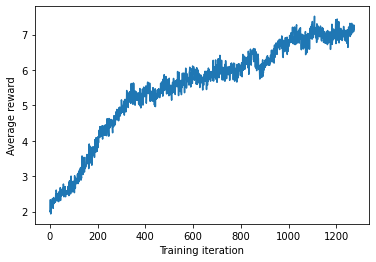

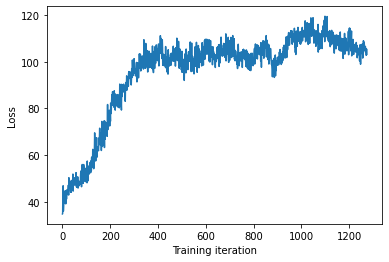



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.42it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.42it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.42it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.42it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 27.42it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.47it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.47it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.47it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 28.47it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:06, 28.65it/s]

Generating molecul

Percentage of predictions within drug-like region: 0.9553072625698324
Proportion of valid SMILES: 0.895


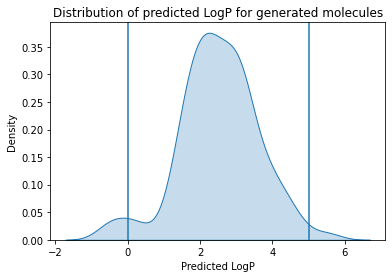



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                     
C=C(C)Oc1ccccc1-c1nnccc1-c1ccc(-c2ccccn2)nc1                          
CC(=C(c1cnnnn1)c1cnnn1-c1ccccc1)c1cnn(C2CCC2)c1                       
CC(=O)N(CCN1CCCC(n2ccnc2)C1)c1ncncn1                                  
CC(=O)Nc1cccc(-c2nnnn2)n1                                             




Policy gradient...:   7%|▋         | 1/15 [00:01<00:19,  1.42s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:18,  1.40s/it]

Policy gradient...:  20%|██        | 3/15 [00:04<00:16,  1.36s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.33s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.25s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.21s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.19s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.18s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.15s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.14s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.10s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.14s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.12s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.16s/it]

Policy gradient...: 100%|██████████| 15/1

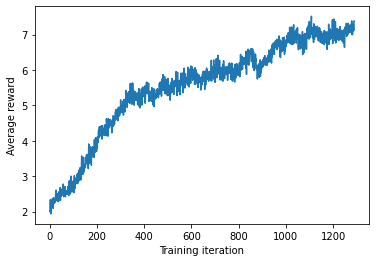

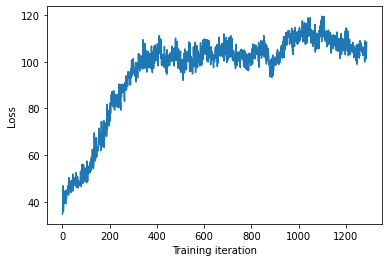



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.08it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.08it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.08it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.08it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.68it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.68it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.68it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.68it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.68it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9679144385026738
Proportion of valid SMILES: 0.935


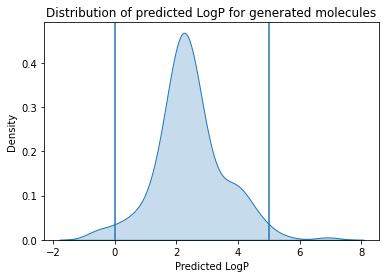



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                             
CC(=Cc1ccccn1)c1cnnnc1-c1cccnc1                                               
CC(=O)Nc1ccccc1n1ncc2cccnc21                                                  
CC(=O)Nc1ncnnc1-c1cnnnc1                                                      
CC(=O)OCc1ccccc1-c1ncc(-c2nccn2CCCCCOc2ccncc2)nn1                             




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.20s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:15,  1.20s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.17s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.13s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.14s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.19s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.24s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.20s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.16s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.19s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.19s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.16s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.13s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.19s/it]

Policy gradient...: 100%|██████████| 15/1

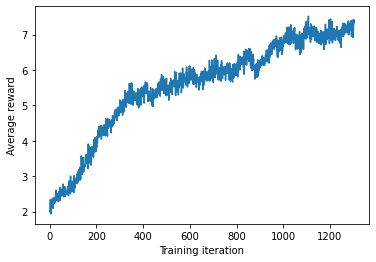

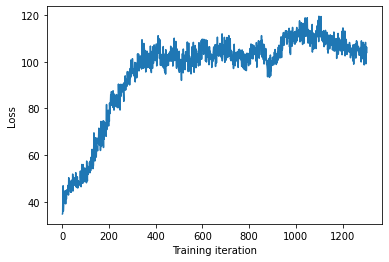



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.85it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.85it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.85it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.85it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.97it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.97it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.97it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.97it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.97it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9351351351351351
Proportion of valid SMILES: 0.925


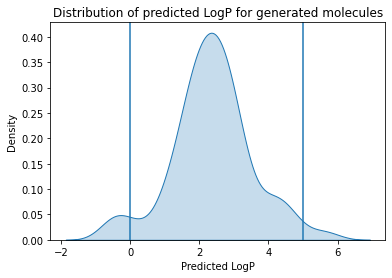



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1ccc(-c2ncnn2CCc2ccccc2)cc1                                          
CC(=O)Nc1cccc(C=Cc2occc2C(=O)CCCc2ccccc2)c1                                  
CC(=O)Nc1cnnn1-c1cccnc1                                                      
CC(=O)Oc1ccc2nc(-c3ccncc3)cnc2c1                                             
CC(=O)c1ccc(-c2nccnc2-c2ccc(OC(=O)c3cncn3Cc3ccccc3)c(C)c2)cc1                




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.16s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:15,  1.16s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.18s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:13,  1.21s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.22s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.20s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.18s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.20s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.21s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.17s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:04,  1.18s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.18s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.15s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.16s/it]

Policy gradient...: 100%|██████████| 15/1

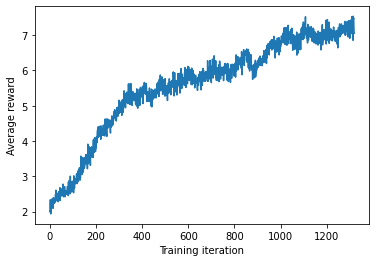

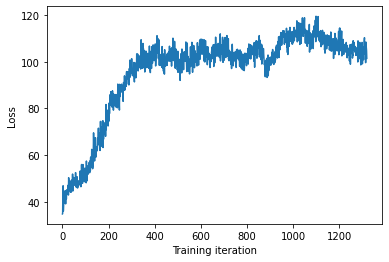



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.28it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.28it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.28it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.28it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.28it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.90it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.90it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.90it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.90it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.967032967032967
Proportion of valid SMILES: 0.91


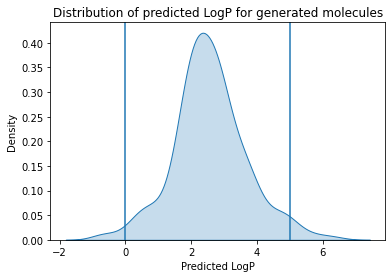



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1cc(-c2cncnc2)cnc1-c1nnnn1                                                 
CC(=O)Nc1cncnc1COc1ccccc1Br                                                        
CC(=O)Nc1cnnnc1-c1ccc(-c2cccc(-c3ncncn3)n2)o1                                      
CC(=O)Nc1ncnc(-c2cccnc2)n1                                                         
CC(=O)Nc1nncn1Cc1ccccc1-c1nccn1Cc1ccccn1                                           




Policy gradient...:   7%|▋         | 1/15 [00:01<00:18,  1.35s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.30s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.22s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.16s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.17s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.19s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.15s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.16s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.17s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.17s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.19s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.19s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.18s/it]

Policy gradient...: 100%|██████████| 15/1

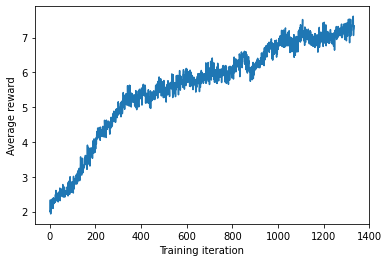

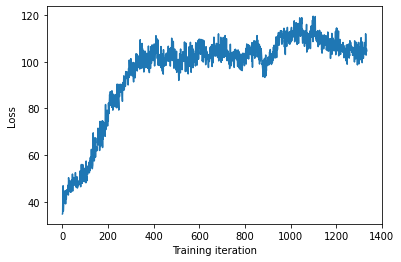



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.77it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.77it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.77it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.77it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.77it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.34it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.34it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.34it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.34it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 29.34it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.9567567567567568
Proportion of valid SMILES: 0.925


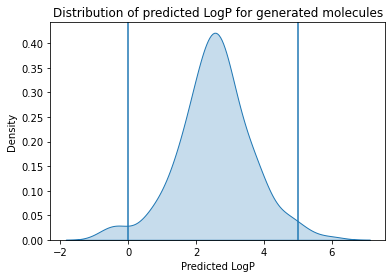



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCN1CCC1C(Oc1ccccc1)c1ccccc1                                            
C=Cc1ncnc(N2CCN(c3ncncn3)CC2)n1                                           
CC(=O)C(Nc1nnnnn1)c1ccncc1                                                
CC(=O)NC1CCN(Cc2cncnc2)CC1CC(c1cncnc1)N1CCCCCC1                           
CC(=O)NCC(O)c1ccc2cnnnc2c1Nc1cccc(-c2nccn2C)n1                            




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.14s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.14s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.18s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:05<00:14,  1.27s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:06<00:12,  1.22s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.19s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.21s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.17s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.22s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:12<00:05,  1.18s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:04,  1.23s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.19s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.18s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.15s/it]

Policy gradient...: 100%|██████████| 15/1

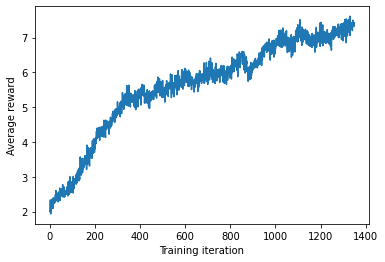

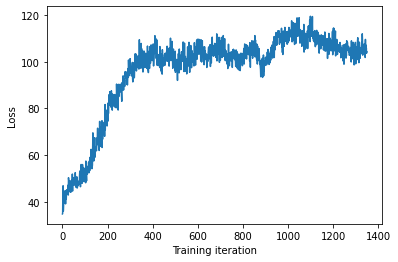



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.79it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.79it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.79it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.79it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.79it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:06, 28.79it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.40it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.40it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.40it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:06, 31.40it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.9120879120879121
Proportion of valid SMILES: 0.91


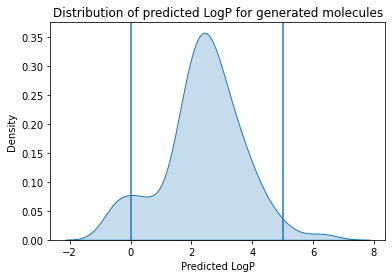



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                     
C=C(C)c1ccccc1C(=Nc1ccccc1)c1cnnn1                                    
C=CCN(c1ncncn1)C(C)c1nccnn1                                           
CC(=O)N1CCc2ccc(S(=O)(=O)Nc3ccncc3)cc2C1                              
CC(=O)NCCc1cccc(-c2nnc(N(Cc3ccncn3)C(=O)c3cccnc3)nc2C)c1              




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.20s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.15s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.16s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.14s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.10s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.18s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.20s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.21s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:06,  1.21s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:04,  1.24s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.27s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.24s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.27s/it]

Policy gradient...: 100%|██████████| 15/1

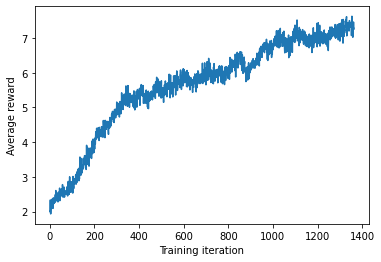

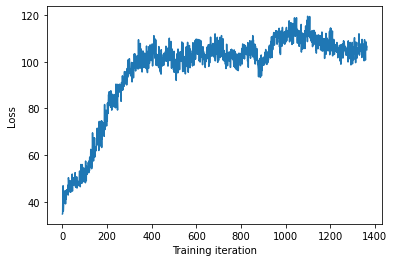



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.21it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.21it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.21it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 31.21it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.46it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.46it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.46it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.46it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 30.46it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9550561797752809
Proportion of valid SMILES: 0.89


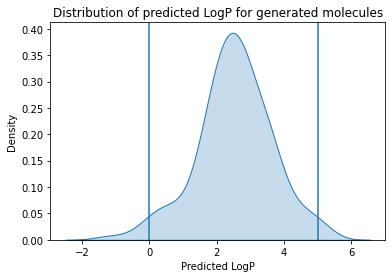



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)NCCNc1cc2c(n1)Sc1ccc(-c3ccnnc3)nc1NC2=O                                      
CC(=O)Nc1cc(-c2nc(-c3ccccc3)ncc2-c2nncCC(n3cccc3)cc2-c2ccccn2)ccn1                 
CC(=O)Nc1ccc(-c2nnc(N=C3C(=O)Nc4ccc(F)cc43)s2)cc1                                  
CC(=O)Nc1ncccc1Nc1cnnc2nccnc12                                                     
CC(=O)Nc1nnc(n2cccc2-c2nccnn2)nc1C                                                 




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.04s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.08s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.15s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.19s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.19s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.16s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:07,  1.10s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.14s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:06,  1.20s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.23s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.22s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.24s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.24s/it]

Policy gradient...: 100%|██████████| 15/1

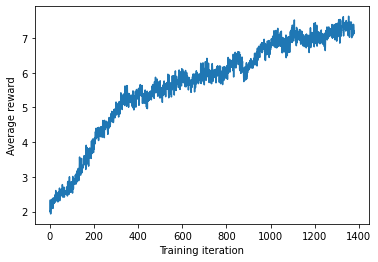

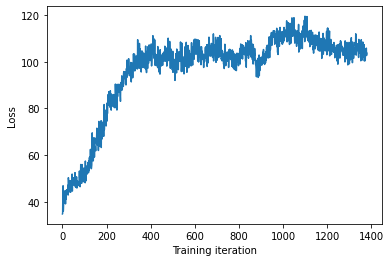



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.86it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.86it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.86it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.86it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.86it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.47it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.47it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.47it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.47it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9166666666666666
Proportion of valid SMILES: 0.9


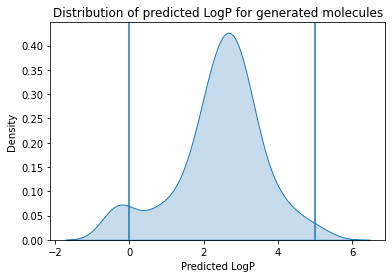



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C1=C(COCc2ccccc2)nc2cncc(-c3nccnc3Nc3ncnn3-c3cnccn3)c21           
C=CCN1=C(S(=O)(=O)N2CCC(c3cncnc3)C2)Nc2ccc(C)cc21                 
CC(=O)Nc1ccccc1-c1ncnn1Cc1nccn1C                                  
CC(=O)Nc1ncnc2n3nn(CC(N)=O)cc3S(=O)(=O)N2Cc2ccccc21               
CC(=O)Nc1ncnnc1-c1ccc(-c2cccnc2)nn1                               




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.12s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.13s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.15s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.18s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.17s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.22s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:10,  1.26s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.23s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.21s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.18s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:13<00:04,  1.19s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.16s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.17s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.18s/it]

Policy gradient...: 100%|██████████| 15/1

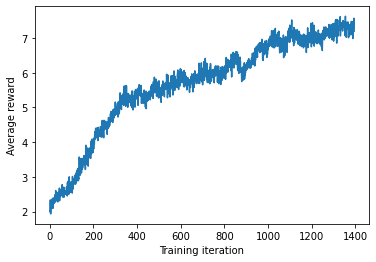

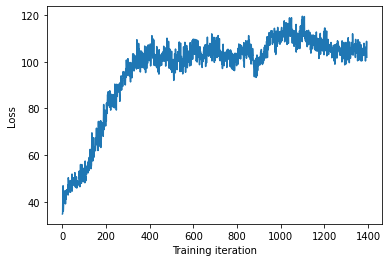



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.41it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.41it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.41it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.41it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.41it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 33.48it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 33.48it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 33.48it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 33.48it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9615384615384616
Proportion of valid SMILES: 0.91


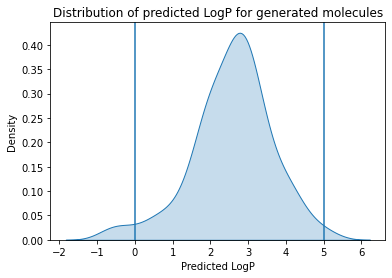



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=N)c1ccccc1n1cc(CNC(=O)c2cccnc2)cn1                               
CC(=O)Nc1ncncn1                                                      
CC(C)(C)NC(=O)c1cnnn1                                                
CC(C)(C)c1ncncc1-c1ncnn1-c1ncncc1-c1cnnn1                            
CC(C)c1cnccn1                                                        




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.09s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.13s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.16s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.18s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.18s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.17s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.14s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:07,  1.13s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.18s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.16s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.15s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.14s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.15s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.18s/it]

Policy gradient...: 100%|██████████| 15/1

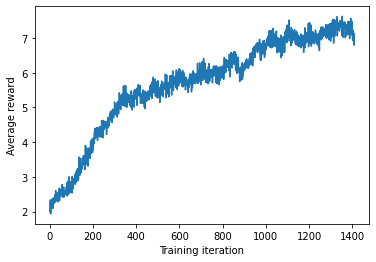

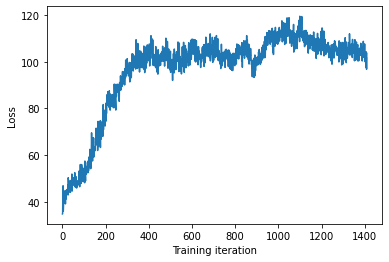



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.29it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.29it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.29it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.29it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.82it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.82it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.82it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.82it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 31.82it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9337016574585635
Proportion of valid SMILES: 0.905


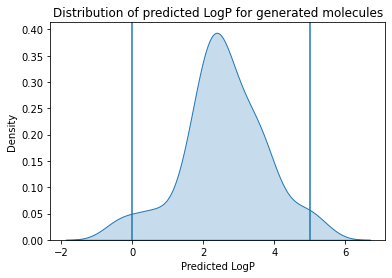



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C(OCC)c1cccc(S(=O)(=O)Nc2nccn2Cc2cccc(C)c2)c1                             
CC(=O)Nc1ncnc2ncnnc12                                                       
CC(=O)n1nccc1-c1ncnn1CCCN1CCC(c2nncn2-c2nccn2Cc2cccnc2)CC1                  
CC(C)=Cc1cnnn1-c1cnccn1                                                     
CC(C)Brc1nncn1Cc1cncc(-c2ccccn2)n1                                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.09s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.10s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.11s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.13s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.13s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.18s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.17s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.19s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.18s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.19s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.20s/it]

Policy gradient...:  80%|████████  | 12/15 [00:14<00:03,  1.22s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.24s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.22s/it]

Policy gradient...: 100%|██████████| 15/1

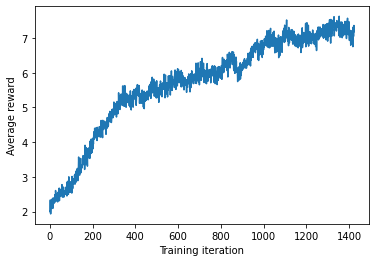

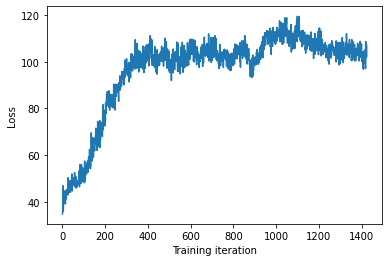



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.36it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.36it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.36it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.36it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.36it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.86it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.86it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.86it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.86it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9508196721311475
Proportion of valid SMILES: 0.915


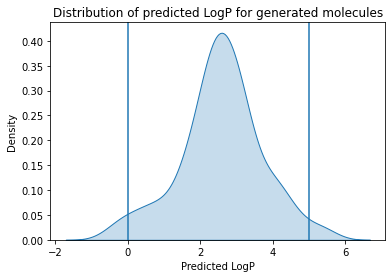



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1cccc(S(=O)(=O)Nc2ncncn2)c1                                      
CC(=O)Nc1cccc2cc(NC(=O)Nc3ccccc3)ncn12                                   
CC(=O)Nc1ccccc1C(=O)Nc1ccnnc1S(=O)(=O)c1ccccn1                           
CC(=O)Nc1ccnc(Nc2ncncn2)n1                                               
CC(=O)Nc1ncccn1                                                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.11s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.08s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.06s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.16s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.14s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.11s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.12s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.17s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.13s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.10s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.09s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.06s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.05s/it]

Policy gradient...: 100%|██████████| 15/1

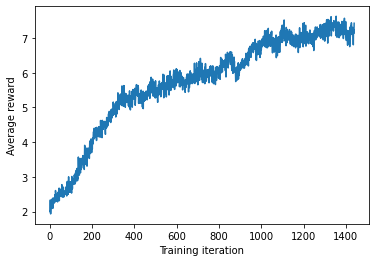

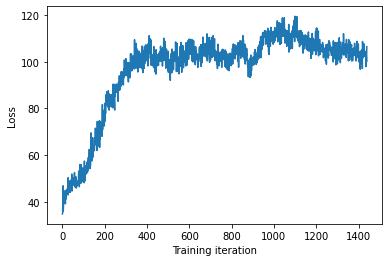



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.76it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.76it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.76it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.76it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 36.76it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.97it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.97it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.97it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.97it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9662921348314607
Proportion of valid SMILES: 0.89


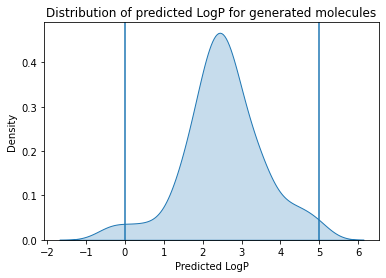



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCNC(=O)COc1ccccc1-c1ncncn1                                  
C=CCNc1nnccn1-c1ccccn1                                         
CC(=O)N(C1CCC(Cc2cc(Nc3ccccc3)ncn2)nn1)C1OC(CO)C(O)C1O         
CC(=O)Nc1ccc2cc(-c3cnccc3Oc3ccccn3)cnn12                       
CC(=O)Nc1cccc(-c2cncnc2-c2cncnc2)c1                            




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.09s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.15s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.12s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.13s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.18s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.20s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.18s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:08,  1.18s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.15s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.15s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.16s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.15s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:15<00:02,  1.17s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:16<00:01,  1.18s/it]

Policy gradient...: 100%|██████████| 15/1

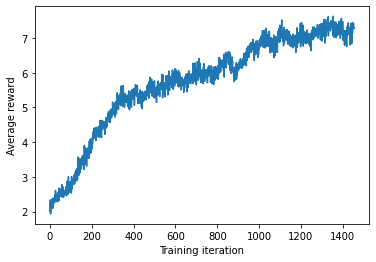

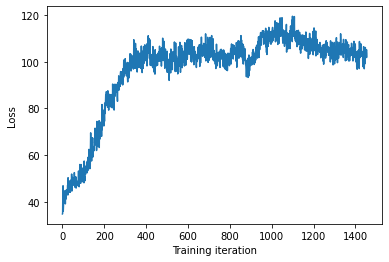



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.49it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.49it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.49it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.49it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.49it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.83it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.83it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.83it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.83it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9325842696629213
Proportion of valid SMILES: 0.89


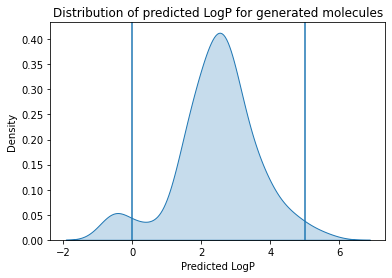



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=NNC(=O)c1ccccc1F)c1ccc2c(c1n1CCNCC1)-n1ccccc1S2                     
CC(=O)Nc1ccc2ccnc(-c3ccccn3)-c3cncn3c2c1                                
CC(=O)Nc1cccnc1Nc1ncncn1                                                
CC(=O)c1ccccc1NCc1nnnc1C                                                
CC(=O)c1ccccc1Nc1ncnnc1-c1ccncn1                                        




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.09s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.12s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.08s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.09s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.12s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:09,  1.16s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:07,  1.13s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.13s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.13s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.11s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.14s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.12s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.16s/it]

Policy gradient...: 100%|██████████| 15/1

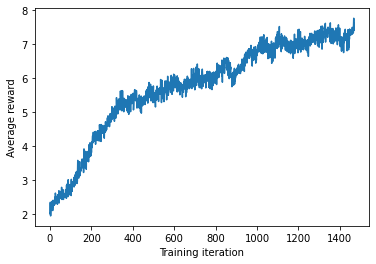

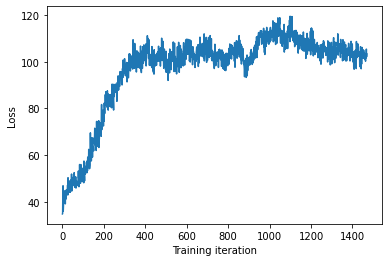



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.64it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.64it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.64it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.64it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:06, 32.64it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.13it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.13it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.13it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.13it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9502762430939227
Proportion of valid SMILES: 0.905


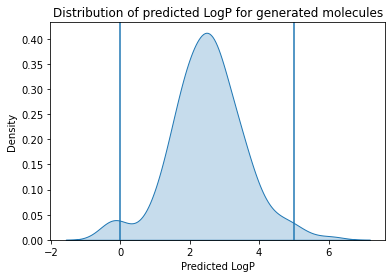



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CC(=NNc1ncccn1)c1nnc(Cc2ccccc2-n2ccnc2)nc1-c1ccnnc1           
CC(=O)C(C)c1c(-c2nnc(-c3ccccc3Nc3ccccn3)o2)nncO1                
CC(=O)Nc1ccccn1                                                 
CC(=O)Oc1nccnc1-c1cnccn1                                        
CC(C(=O)NCC(=O)Nc1ncncc1-c1cccnc1)c1ccnnc1                      




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.17s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:15,  1.18s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.17s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.13s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.10s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.10s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.10s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.09s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.07s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.08s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.07s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.07s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.08s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.12s/it]

Policy gradient...: 100%|██████████| 15/1

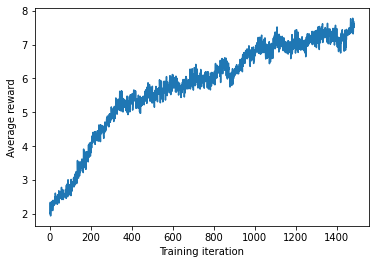

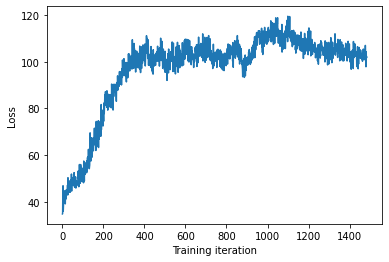



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 35.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 35.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 35.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 35.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 35.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 35.49it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:05, 37.39it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:05, 37.39it/s]

Generating molecules...:   5%|▌  

Percentage of predictions within drug-like region: 0.9402173913043478
Proportion of valid SMILES: 0.92


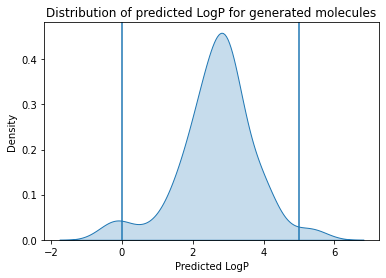



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C1=nN(Cc2cncn2)CC(c2ncncn2)CCC(NCc2ccccn2)C1                          
CC(=O)Nc1ccccc1Oc1nccnc1-c1ccncc1                                     
CC(=O)Nc1ccncn1                                                       
CC(=O)Nc1cncnn1                                                       
CC(=O)Nc1ncnc(-c2ccnnc2)n1                                            




Policy gradient...:   7%|▋         | 1/15 [00:01<00:17,  1.22s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.26s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.21s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.17s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.13s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.11s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:07,  1.10s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:07,  1.18s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.14s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.15s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.13s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.11s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.09s/it]

Policy gradient...: 100%|██████████| 15/1

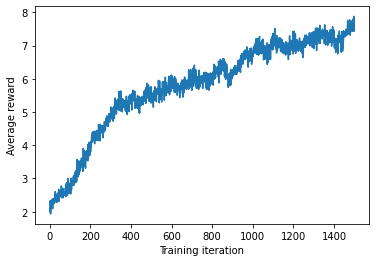

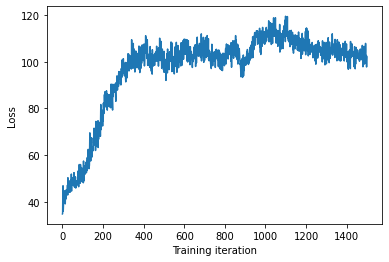



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 1/200 [00:00<00:30,  6.56it/s]

Generating molecules...:   0%|          | 1/200 [00:00<00:30,  6.56it/s]

Generating molecules...:   0%|          | 1/200 [00:00<00:30,  6.56it/s]

Generating molecules...:   0%|          | 1/200 [00:00<00:30,  6.56it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:22,  8.56it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:22,  8.56it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:22,  8.56it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:22,  8.56it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:22,  8.56it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:22,  8.56it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:16, 11.35it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:16, 11.35it/s]

Gen

Percentage of predictions within drug-like region: 0.9444444444444444
Proportion of valid SMILES: 0.9


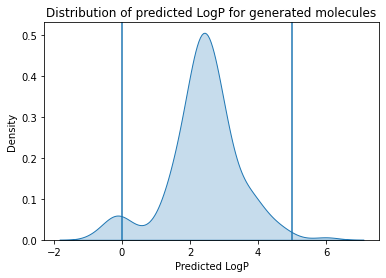



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCN1CCN(C(=O)c2cccc(-c3ncncn3)c2)CC1                       
CC(=O)Nc1ccc(S(=O)(=O)N2CCN(c3ncncn3)CC2)cn1                 
CC(=O)Nc1ccc2ncnc(NCc3ccc(S(=O)(=O)Nc4cc(N)ncn4)cc3)n2n1     
CC(=O)Nc1ccccc1Nc1ncncn1                                     
CC(=O)c1cncc2ccccc12c1ncncn1                                 




Policy gradient...:   7%|▋         | 1/15 [00:01<00:18,  1.29s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:16,  1.23s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.19s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.16s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.10s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.11s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.10s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.08s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.09s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.09s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.11s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.16s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.12s/it]

Policy gradient...: 100%|██████████| 15/1

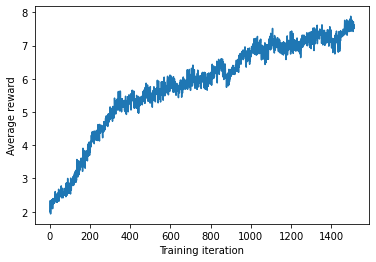

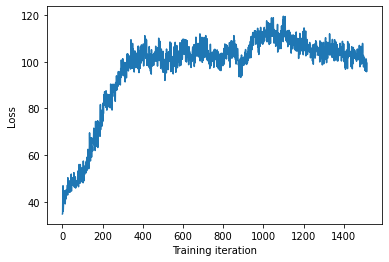



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 37.23it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 37.23it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 37.23it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 37.23it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 37.23it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.66it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.66it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.66it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.66it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9661016949152542
Proportion of valid SMILES: 0.885


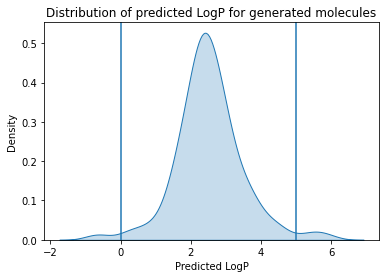



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C#Cc1cncnc1-c1ccncc1S(=O)(=O)c1cccnc1                                 
C=CCN1Cc2ccnc(OC)c2nc(OC)ncn1                                         
CC(=O)NCCc1cnnn1                                                      
CC(=O)Nc1cncc(S(=O)(=O)c2ccc(-c3[nH]ncc3-c3ncnn3-c3ccccc3)cc2)n1      
CC(C)(O)c1ncncn1-c1ccccc1                                             




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.02s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.08s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.13s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.10s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.08s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.12s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.10s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.12s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.14s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.11s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.08s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.12s/it]

Policy gradient...: 100%|██████████| 15/1

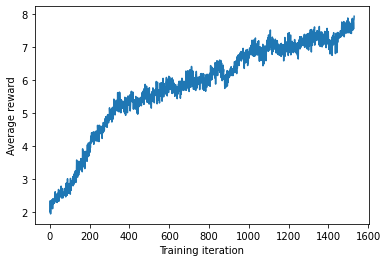

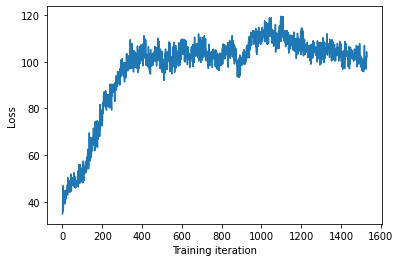



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 33.39it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 33.39it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 33.39it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 33.39it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 33.39it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9613259668508287
Proportion of valid SMILES: 0.905


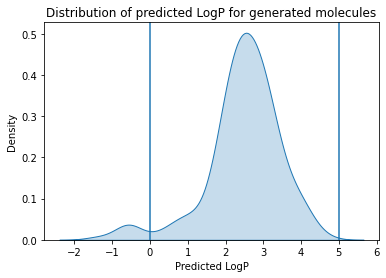



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=NNC(=O)c1cccc(-c2ccncc2)n1)c1ccncn1                              
CC(=NNC(=O)c1cccnn1)c1cccnc1                                         
CC(=NNc1nc[nH]n1)c1cccnn1                                            
CC(=NNc1ncncn1)c1cnncn1                                              
CC(=O)Nc1ccccc1c1ncnn1                                               




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.14s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.09s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.12s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.17s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.08s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.03s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.06s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.08s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.07s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.05s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.06s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.07s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.07s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.07s/it]

Policy gradient...: 100%|██████████| 15/1

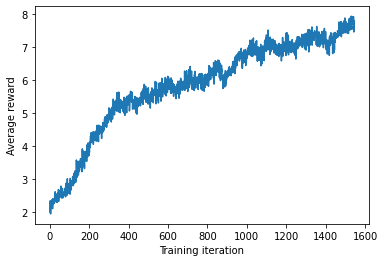

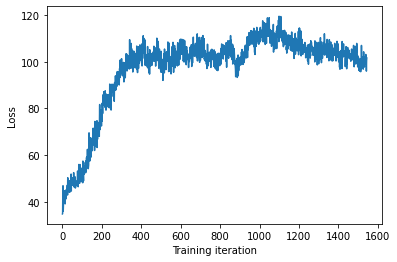



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 26.13it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 26.13it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 26.13it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 26.13it/s]

Generating molecules...:   2%|▏         | 3/200 [00:00<00:07, 26.13it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.70it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.70it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.70it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.70it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:06, 27.70it/s]

Generating molecule

Percentage of predictions within drug-like region: 0.9558011049723757
Proportion of valid SMILES: 0.905


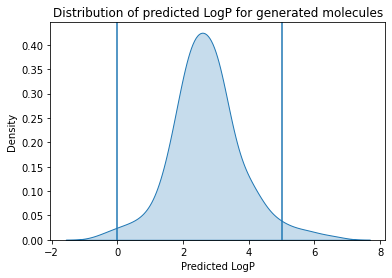



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C1C=CNc2ncncc21                                                 
C=CC=CC=CC=CC=CCc1ccccc1                                          
CC(=NNC(=S)c1cnnn1)c1ncncn1                                       
CC(=O)C=C(C(=O)Nc1cnccn1)c1ccnc(N2CCc3ccccc32)n1                  
CC(=O)c1cccnc1-c1cnnc(C(=O)Nc2ncncn2)n1                           




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.14s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.13s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.18s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.17s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Policy gradient...:  40%|████      | 6/15 [00:07<00:10,  1.19s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:08<00:09,  1.17s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:09<00:07,  1.13s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.09s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.07s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.08s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.09s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.08s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.15s/it]

Policy gradient...: 100%|██████████| 15/1

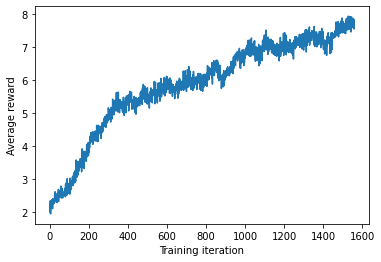

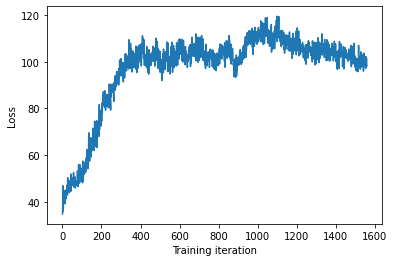



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.87it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.87it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.17it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.17it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.17it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.17it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9340659340659341
Proportion of valid SMILES: 0.91


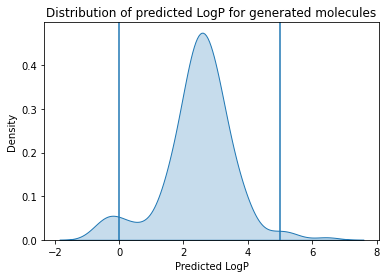



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=CCCC=CCCC(C)OCC(=O)Nc1ccccc1C(=O)Nc1ccccc1-c1nnno1)c1ccccc1                    
CC(=O)Nc1ccccc1-c1cc(-c2cnnn2)ncn1                                                 
CC(=O)Nc1ccnc(-c2ccncc2-c2ncnnn2)c1                                                
CC(C)(Cc1ccccc1)(c1cnncn1)c1cnnn1                                                  
CC(C)(OCCn1c(-c2ncnn2)nnc1n1cncn1)c1ccnnc1                                         




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.19s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.15s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:14,  1.17s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.13s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.09s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.10s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.07s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.06s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.04s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.04s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.13s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.11s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.10s/it]

Policy gradient...: 100%|██████████| 15/1

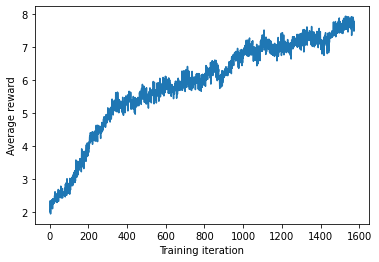

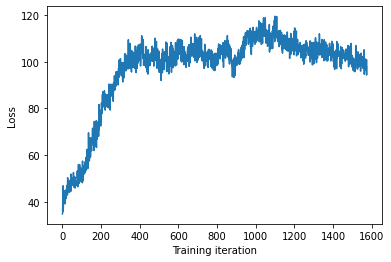



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.10it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.10it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.10it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.10it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 34.10it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.34it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9725274725274725
Proportion of valid SMILES: 0.91


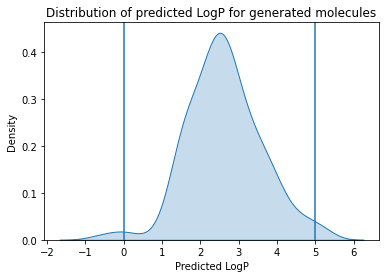



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1ccccc1Nc1ncnnn1                                                     
CC(=O)Nc1nnc(-c2ccncc2)nc1-c1ccccn1                                          
CC(=O)Oc1ccccc1-c1nnc(-c2nccnc2-c2ccccc2-c2nnnnn2)nc1-c1ccccc1               
CC(=O)c1ccccc1CSc1ncnn1CCOc1cccnc1                                           
CC(=O)c1ccnc(-c2ccnc(-c3cnnn3)c2)n1                                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.12s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.11s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.10s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.14s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.15s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.14s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.10s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.11s/it]

Policy gradient...:  60%|██████    | 9/15 [00:10<00:06,  1.12s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:11<00:05,  1.10s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:12<00:04,  1.07s/it]

Policy gradient...:  80%|████████  | 12/15 [00:13<00:03,  1.05s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.10s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.08s/it]

Policy gradient...: 100%|██████████| 15/1

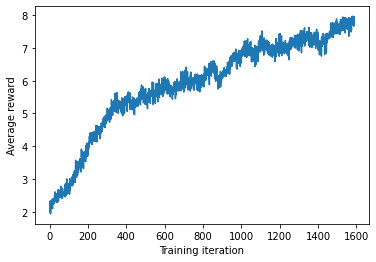

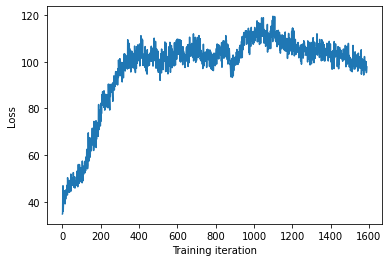



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 38.37it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 38.37it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 38.37it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:09, 20.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:09, 20.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:09, 20.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:09, 20.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:09, 20.67it/s]

Generating molecules...:   4%|▎    

Percentage of predictions within drug-like region: 0.9447513812154696
Proportion of valid SMILES: 0.905


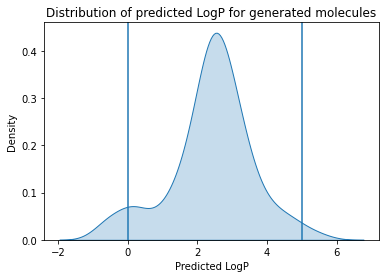



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1cncnc1Nc1ccccn1                                               
CC(=O)Nc1ncncn1                                                        
CC(=O)c1ccc(-c2ncc(-c3cccnn3)nn2)nc1                                   
CC(=O)c1ccc(-c2ncnc(-c3cccnc3)n2)cn1                                   
CC(=O)c1cccc(-c2ncncc2Cc2nnc(-c3ccccc3)nn2)c1                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:15,  1.09s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.14s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.11s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.08s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.07s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.06s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.05s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.07s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.07s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.07s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.10s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.06s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.02s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.01s/it]

Policy gradient...: 100%|██████████| 15/1

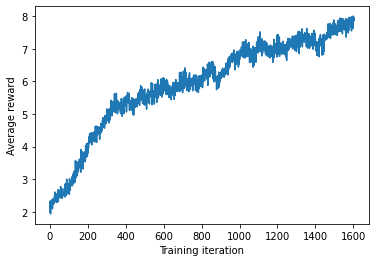

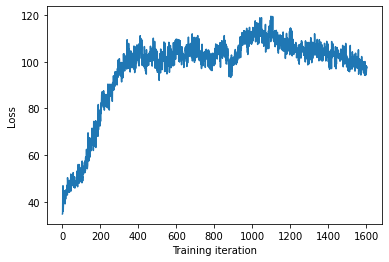



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.92it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.92it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.92it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.92it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.92it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.25it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.25it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.25it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.25it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.953757225433526
Proportion of valid SMILES: 0.865


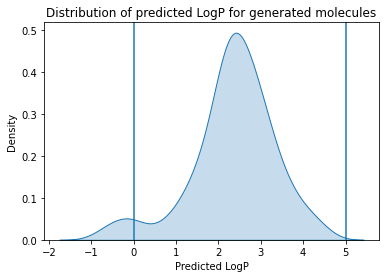



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
Brc1ncnnc1-c1ccnnc1                                                            
CC(=O)N1CCc2cc(N3CCCCC(=O)n4cncc43)ccc21                                       
CC(=O)Nc1ccc(NC(=O)c2cnnn2c2cn(C)cn2)cc1                                       
CC(=O)Nc1nnnc(-c2ccccn2)n1                                                     
CC(=O)Oc1ncccc1Oc1nccnc1-c1cncnc1                                              


./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.20s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.14s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.11s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.15s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.11s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.07s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.08s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.08s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.11s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.10s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.06

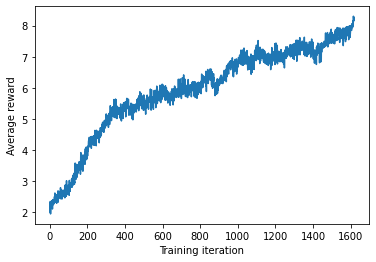

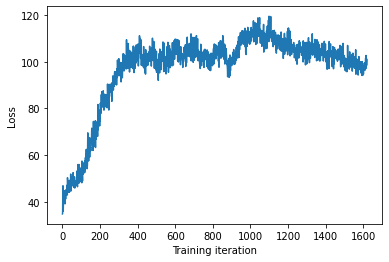



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.69it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.69it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.69it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.69it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.69it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.23it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9783783783783784
Proportion of valid SMILES: 0.925


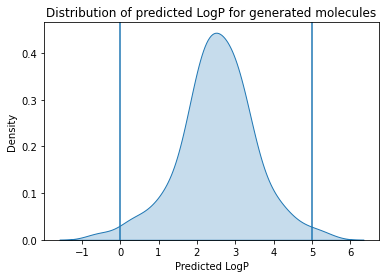



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                                  
CC(=O)N(c1nncnc1CF)c1nonc1-c1ccccc1                                
CC(=O)Nc1ccc(-c2ncnn2-c2ccncc2)cn1                                 
CC(=O)Nc1cnccn1                                                    
CC(=O)c1cncnc1Oc1ccccc1C=Cc1nnnn1C1CCCCC1                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.02s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.03s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.08s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.06s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.05s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.05s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.04s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.05s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.02s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.01s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.07s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.04s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.03s/it]

Policy gradient...: 100%|██████████| 15/1

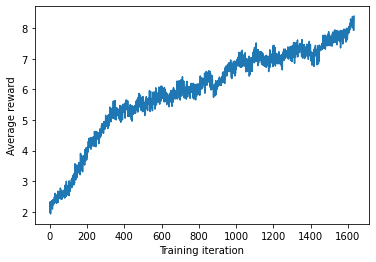

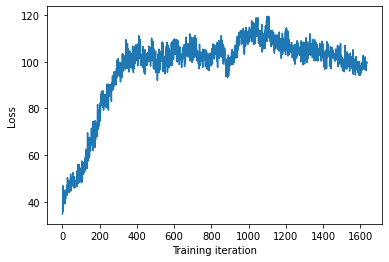



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.60it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.60it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.60it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.60it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.60it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.82it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.82it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.82it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.82it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9668508287292817
Proportion of valid SMILES: 0.905


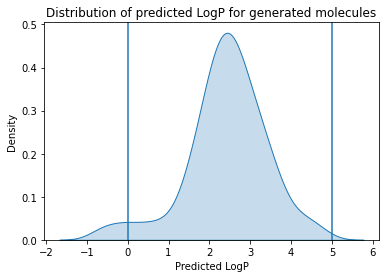



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=NNC(=O)Nc1nccn1Cc1ccccc1)c1cccnn1                      
CC(=O)Nc1ccc(-c2ncnc3c2nnn3-c2cccnc2)cn1                   
CC(=O)Nc1ccccc1C(Cc1ccccn1)c1ccnc(-c2ccncn2)n1             
CC(=O)Nc1ncncn1                                            
CC(=O)Nc1nncnn1                                            




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.04s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.03s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.03s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:08,  1.00it/s]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.00s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.01s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.08s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.07s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.12s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.09s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.08s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.03s/it]

Policy gradient...: 100%|██████████| 15/1

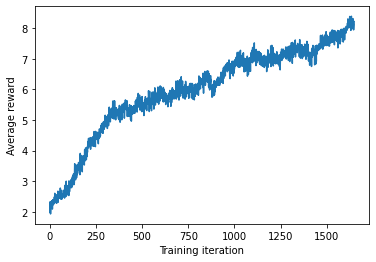

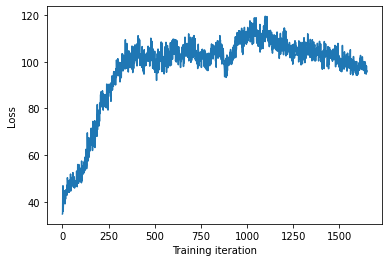



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.62it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.62it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.62it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.62it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.62it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 41.19it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 41.19it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 41.19it/s]

Generating molecules...:   4%|▍    

Percentage of predictions within drug-like region: 0.9776536312849162
Proportion of valid SMILES: 0.895


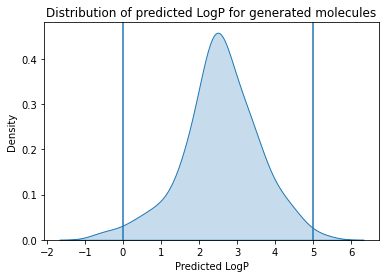



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=NNc1nccnc1-c1cncnc1)c1ccnn1                               
CC(=NNc1nccnc1Oc1ccc(-c2ncnnn2)cc1)c1nccnc1Nc1ccccn1          
CC(=O)C1=C(C)Nc2ccccc2-c2ncnnc21                              
CC(=O)Nc1ccccc1-c1nccnc1N1CCN(C(=O)Fc2ccccc2C)CC1             
CC(=O)c1ccccc1Nc1ncncn1                                       




Policy gradient...:   7%|▋         | 1/15 [00:01<00:16,  1.15s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.14s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:13,  1.15s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:12,  1.12s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:11,  1.11s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:10,  1.12s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.09s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.03s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.06s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.04s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.04s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.08s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:14<00:02,  1.07s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:15<00:01,  1.10s/it]

Policy gradient...: 100%|██████████| 15/1

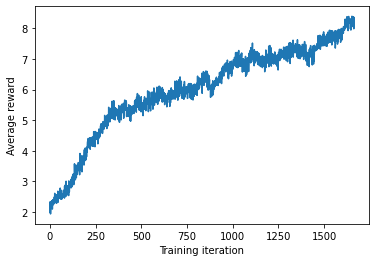

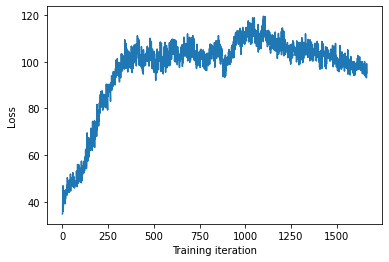



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.58it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.58it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.58it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.58it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 33.58it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.11it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.11it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.11it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 35.11it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.949438202247191
Proportion of valid SMILES: 0.89


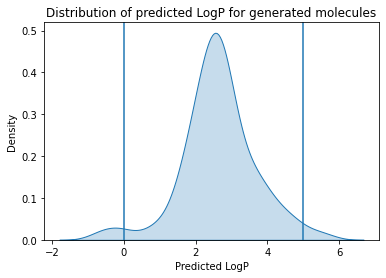



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C(C)COc1ccccc1N1CCSC1=Cc1ncncc1Cl                                  
C=C(C)c1ccc(-c2nccnc2-c2ncncn2)cc1                                   
CBrCCCC1(O)COc2ccccc2N1CCCOc1ccccc1COc1ccccc1                        
CC(=Cc1cncnc1)c1ncncn1                                               
CC(=O)Nc1cccnc1C1CCN(S(=O)(=O)c2ccc(C(=O)Nc3ncnc4scnc34)cn2)CC1      




Policy gradient...:   7%|▋         | 1/15 [00:00<00:12,  1.15it/s]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:12,  1.05it/s]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.04s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.07s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.08s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.06s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.06s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.05s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.05s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.06s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.01s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:01,  1.00it/s]

Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.04s/it]

Policy gradient...: 100%|██████████| 15/1

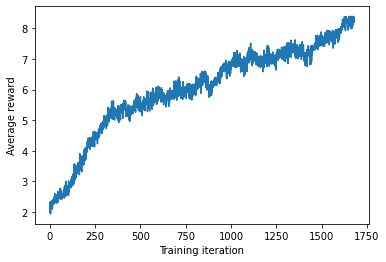

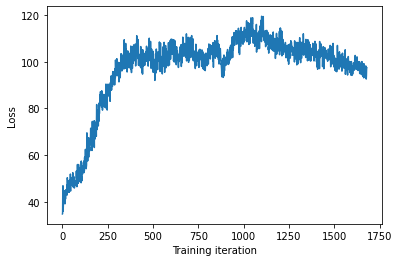



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.79it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.79it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.79it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 38.79it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 34.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 34.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 34.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 34.67it/s]

Generating molecules...:   4%|▎         | 7/200 [00:00<00:05, 34.67it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9615384615384616
Proportion of valid SMILES: 0.91


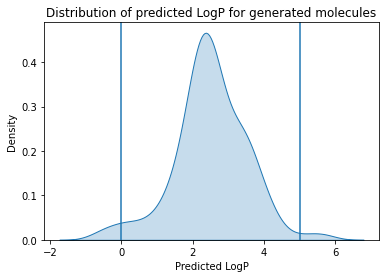



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)c1ccccc1-c1ccncc1                                               
CC(=O)c1ccccc1CNc1ncncn1                                              
CC(=O)c1ncccc1-n1nccn1                                                
CC(=O)n1ccnc1C(c1ccc(-c2ccncn2)cc1)c1ncnn1-c1ccc(-c2cnccn2)cc1        
CC(C)(CC(=O)Nc1ncncc1-c1ncnn1Cc1ccc(N(=O)=O)nc1)c1cccnc1              




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.03s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.04s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.00s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.02s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.01s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.01s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.05s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.01s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.01s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:02,  1.02it/s]

Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.05it/s]

Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.04it/s]

Policy gradient...: 100%|██████████| 15/1

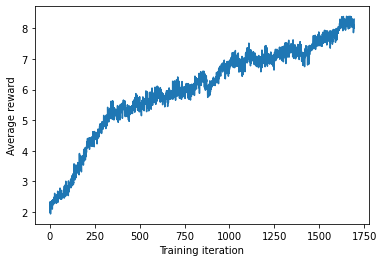

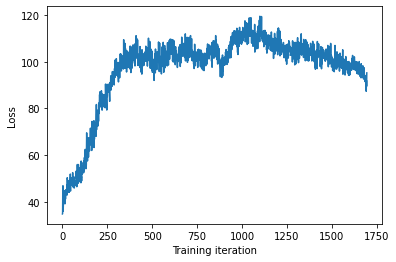



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.42it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.42it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.42it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.42it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:04, 39.42it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 38.14it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 38.14it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 38.14it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 38.14it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.967032967032967
Proportion of valid SMILES: 0.91


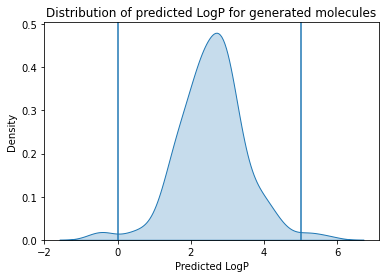



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=C(C)CCn1cnnc1                                                  
CC(=Cc1ccccn1)CCC(=O)OCC(=O)Nc1ccccn1                            
CC(=NNc1nccnc1C)n1ccnc1                                          
CC(=O)OC(C)(c1ccncc1)c1ncnn1                                     
CC(=O)c1ccc(-c2cnc3ccccn23)cc1                                   




Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.07it/s]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.00s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.02s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.05s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.07s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.06s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.01s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.03s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.01s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:04,  1.05it/s]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:03,  1.07it/s]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:02,  1.05it/s]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:01,  1.02it/s]

Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:00,  1.00it/s]

Policy gradient...: 100%|██████████| 15/1

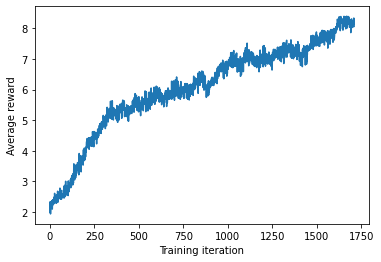

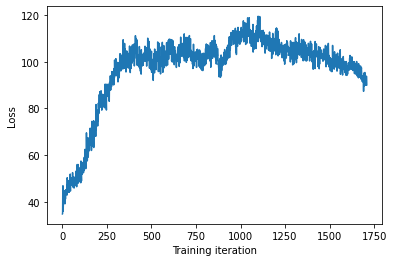



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.52it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.52it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.52it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.52it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.52it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.96it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.96it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.96it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 34.96it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9613259668508287
Proportion of valid SMILES: 0.905


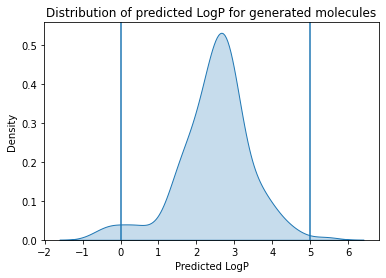



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C                                                            
CC(=O)NC(c1c(-c2ccccc2)nnnC1)c1ccccc1n1ccnc1                 
CC(=O)Nc1ncncn1                                              
CC(C#N)c1ncnn1Cc1cccc(-c2ccnnn2)n1                           
CC(C)(C)OC(=O)Nc1ncnnc1-c1ccncn1                             




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:01<00:13,  1.01s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.01s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.00it/s]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.06s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.07s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.02s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:05,  1.00it/s]

Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.05it/s]

Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.01it/s]

Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.01it/s]

Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.01it/s]

Policy gradient...: 100%|██████████| 15/1

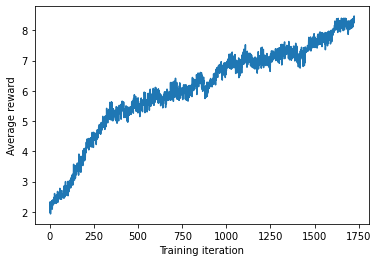

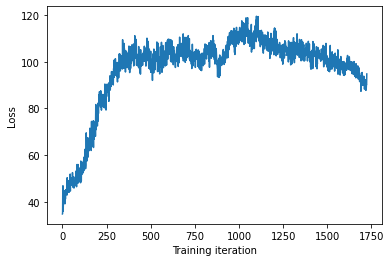



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.49it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 43.49it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 41.21it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 41.21it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 41.21it/s]

Generating molecules...:   4%|▍    

Percentage of predictions within drug-like region: 0.9668508287292817
Proportion of valid SMILES: 0.905


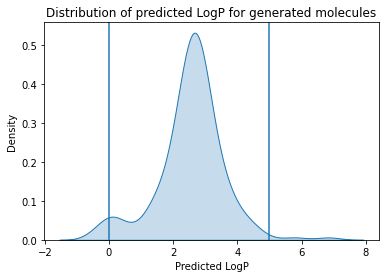



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
C=CCNc1ncnc2nncnc12                                         
CC(=O)Nc1ncnnc1-c1ncnn1-c1cccnc1                            
CC(=O)Nc1nncnn1                                             
CC(=O)c1ccccc1CN(Cc1ccnn1)c1ncnn2cncc12                     
CC(=O)c1cnnn1                                               




Policy gradient...:   7%|▋         | 1/15 [00:00<00:13,  1.02it/s]

Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.01it/s]

Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.05it/s]

Policy gradient...:  27%|██▋       | 4/15 [00:03<00:11,  1.01s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.01s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.04s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.04s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.02s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.02s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.05it/s]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:03,  1.02it/s]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:02,  1.00it/s]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.00s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.03it/s]

Policy gradient...: 100%|██████████| 15/1

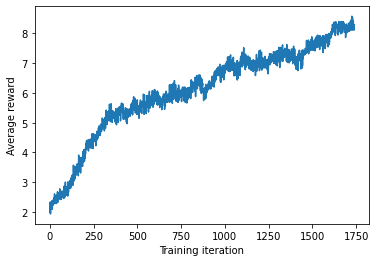

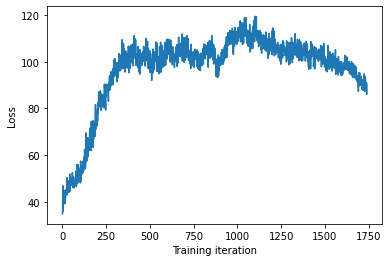



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.53it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.53it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.53it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.53it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 35.53it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.34it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:05, 36.34it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 0.9508196721311475
Proportion of valid SMILES: 0.915


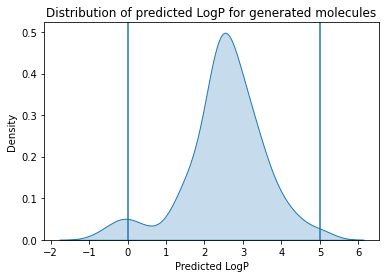



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1ncnnc1C                                                
CC(=O)c1ccccc1-c1ncncn1                                         
CC(=O)c1ccccc1-c1nncnc1Nc1ccccn1                                
CC(=O)c1ccccc1S(=O)(=O)N(C)c1ncncn1                             
CC(C)(Cc1ccc(-c2ncncn2)cn1)c1ccnn1                              




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.06s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:14,  1.12s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.06s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:04<00:11,  1.05s/it]

Policy gradient...:  33%|███▎      | 5/15 [00:05<00:10,  1.04s/it]

Policy gradient...:  40%|████      | 6/15 [00:06<00:09,  1.04s/it]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.06s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.04s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.02s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.04s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:11<00:04,  1.03s/it]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:03,  1.02s/it]

Policy gradient...:  87%|████████▋ | 13/15 [00:13<00:02,  1.06s/it]

Policy gradient...:  93%|█████████▎| 14/15 [00:14<00:01,  1.08s/it]

Policy gradient...: 100%|██████████| 15/1

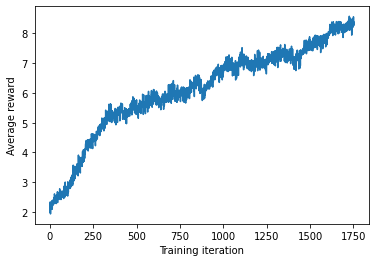

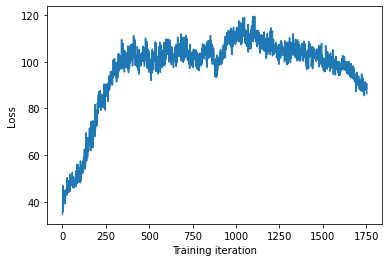



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 39.08it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 39.08it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 39.08it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 39.08it/s]

Generating molecules...:   2%|▏         | 4/200 [00:00<00:05, 39.08it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.53it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.53it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.53it/s]

Generating molecules...:   4%|▍         | 8/200 [00:00<00:04, 38.53it/s]

Generating molecules...:   

Percentage of predictions within drug-like region: 1.0
Proportion of valid SMILES: 0.87


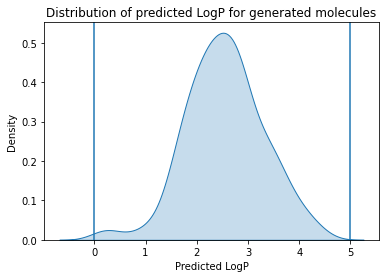



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=NNc1nccnc1Nc1cccnc1)c1ccnnc1                           
CC(=O)Nc1ncncn1                                            
CC(C)=CCc1ccccc1-c1cnnnc1                                  
CC(C)Cc1ncnn1-c1cccnc1                                     
CC(C)c1cccc(-c2nnnnc2-c2ccnnn2)c1                          




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.03s/it]

Policy gradient...:  20%|██        | 3/15 [00:03<00:12,  1.01s/it]

Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.01it/s]

Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.03it/s]

Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.01it/s]

Policy gradient...:  60%|██████    | 9/15 [00:08<00:06,  1.00s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.00it/s]

Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.00it/s]

Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.02it/s]

Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.02it/s]

Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.07it/s]

Policy gradient...: 100%|██████████| 15/1

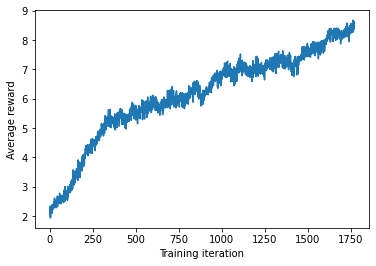

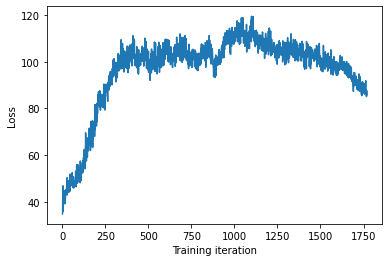



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:03, 48.82it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:03, 48.82it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:03, 48.82it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:03, 48.82it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:03, 48.82it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 44.57it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 44.57it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:04, 44.57it/s]

Generating molecules...:   4%|▍    

Percentage of predictions within drug-like region: 0.9590643274853801
Proportion of valid SMILES: 0.855


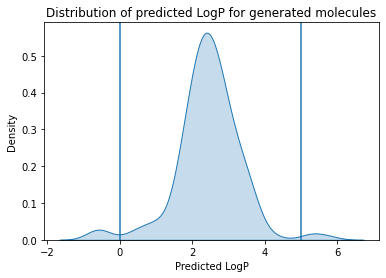



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
CC(=O)Nc1ccnc(-c2cncnn2)c1                                           
CC(=O)c1ccccc1-c1ccnnn1                                              
CC(=O)c1ccccc1Nc1cnccn1                                              
CC(C)Nc1ncncc1C(Nn1cncn1)c1cccnc1                                    
CC(C)c1ccccc1n1nccn1                                                 




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:01<00:12,  1.02it/s]

Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.03it/s]

Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.03it/s]

Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.01it/s]

Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.04it/s]

Policy gradient...:  47%|████▋     | 7/15 [00:07<00:08,  1.11s/it]

Policy gradient...:  53%|█████▎    | 8/15 [00:08<00:07,  1.10s/it]

Policy gradient...:  60%|██████    | 9/15 [00:09<00:06,  1.02s/it]

Policy gradient...:  67%|██████▋   | 10/15 [00:10<00:05,  1.01s/it]

Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.02it/s]

Policy gradient...:  80%|████████  | 12/15 [00:12<00:02,  1.01it/s]

Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.04it/s]

Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.02it/s]

Policy gradient...: 100%|██████████| 15/1

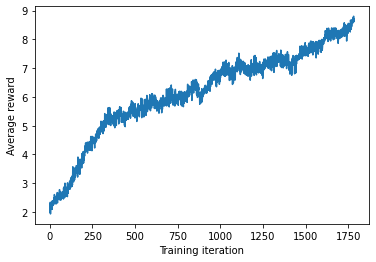

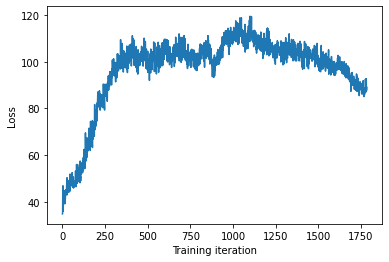



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 34.74it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 34.74it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 34.74it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 34.74it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:05, 34.74it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:05, 35.63it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:05, 35.63it/s]

Generating molecules...:   4%|▍         | 9/200 [00:00<00:05, 35.63it/s]

Generating molecules...:   4%|▍    

Percentage of predictions within drug-like region: 0.9942857142857143
Proportion of valid SMILES: 0.875


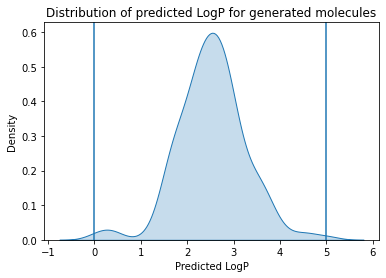



Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Sample trajectories:
Brc1ccccc1CNc1ncncn1                                      
C=CCc1cccnc1-c1ccncn1                                     
CC(=O)Nc1ccccn1                                           
CC(=O)Nc1cccnc1C(=O)Oc1cccnc1C                            
CC(=O)Nc1ncncc1-c1ccccn1                                  




Policy gradient...:   7%|▋         | 1/15 [00:01<00:14,  1.04s/it]

Policy gradient...:  13%|█▎        | 2/15 [00:02<00:13,  1.04s/it]

Policy gradient...:  20%|██        | 3/15 [00:02<00:11,  1.01it/s]

Policy gradient...:  27%|██▋       | 4/15 [00:03<00:10,  1.01it/s]

Policy gradient...:  33%|███▎      | 5/15 [00:04<00:09,  1.02it/s]

Policy gradient...:  40%|████      | 6/15 [00:05<00:08,  1.03it/s]

Policy gradient...:  47%|████▋     | 7/15 [00:06<00:07,  1.07it/s]

Policy gradient...:  53%|█████▎    | 8/15 [00:07<00:06,  1.04it/s]

Policy gradient...:  60%|██████    | 9/15 [00:08<00:05,  1.07it/s]

Policy gradient...:  67%|██████▋   | 10/15 [00:09<00:04,  1.07it/s]

Policy gradient...:  73%|███████▎  | 11/15 [00:10<00:03,  1.06it/s]

Policy gradient...:  80%|████████  | 12/15 [00:11<00:02,  1.05it/s]

Policy gradient...:  87%|████████▋ | 13/15 [00:12<00:01,  1.01it/s]

Policy gradient...:  93%|█████████▎| 14/15 [00:13<00:00,  1.01it/s]

Policy gradient...: 100%|██████████| 15/1

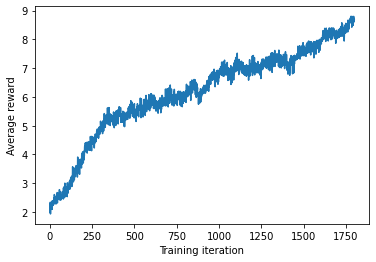

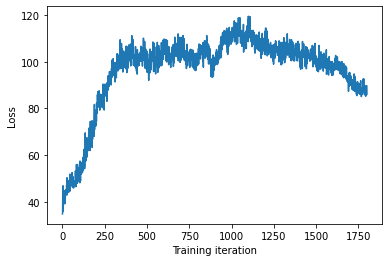



  0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/200 [00:00<?, ?it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 40.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 40.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 40.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 40.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 40.92it/s]

Generating molecules...:   2%|▎         | 5/200 [00:00<00:04, 40.92it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:04, 39.69it/s]

Generating molecules...:   5%|▌         | 10/200 [00:00<00:04, 39.69it/s]

Generating molecules...:   5%|▌  

Percentage of predictions within drug-like region: 0.994535519125683
Proportion of valid SMILES: 0.915


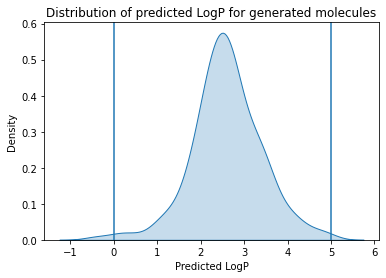

Sample trajectories:
CC(=NNc1cccnn1)c1ncncn1                                   
CC(=O)Nc1ccc(-c2ccncn2)cn1                                
CC(=O)Nc1ncncn1                                           
CC(C)(c1cccnc1)c1ncnnc1-c1ccnn1                           
CC(C)=NC(=O)c1ncnn(-c2cccnc2)c1C(=O)Nc1ccccn1             


In [82]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)



  0%|          | 0/10000 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]./release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()


Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating molecules...:   0%|          | 4/10000 [00:00<05:05, 32.74it/s]

Generating molecules...:   0%|          | 4/10000 [00:00<05:05, 32.74it/s]

Generating molecules...:   0%|          | 4/10000 [00:00<05:05, 32.74it/s]

Generating molecules...:   0%|          | 4/10000 [00:00<05:05, 32.74it/s]

Generating molecules...:   0%|          | 4/10000 [00:00<05:05, 32.74it/s]

Generating molecules...:   0%|          | 8/1000

Percentage of predictions within drug-like region: 0.9823077923767399
Proportion of valid SMILES: 0.7687


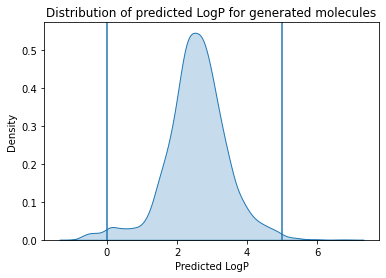

In [83]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       n_to_generate=10000)

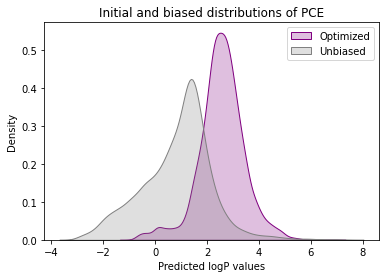

In [84]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted PCE values')
plt.title('Initial and biased distributions of PCE')
plt.legend()
plt.show()

In [85]:
from rdkit.Chem import Draw

In [86]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [87]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased]
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

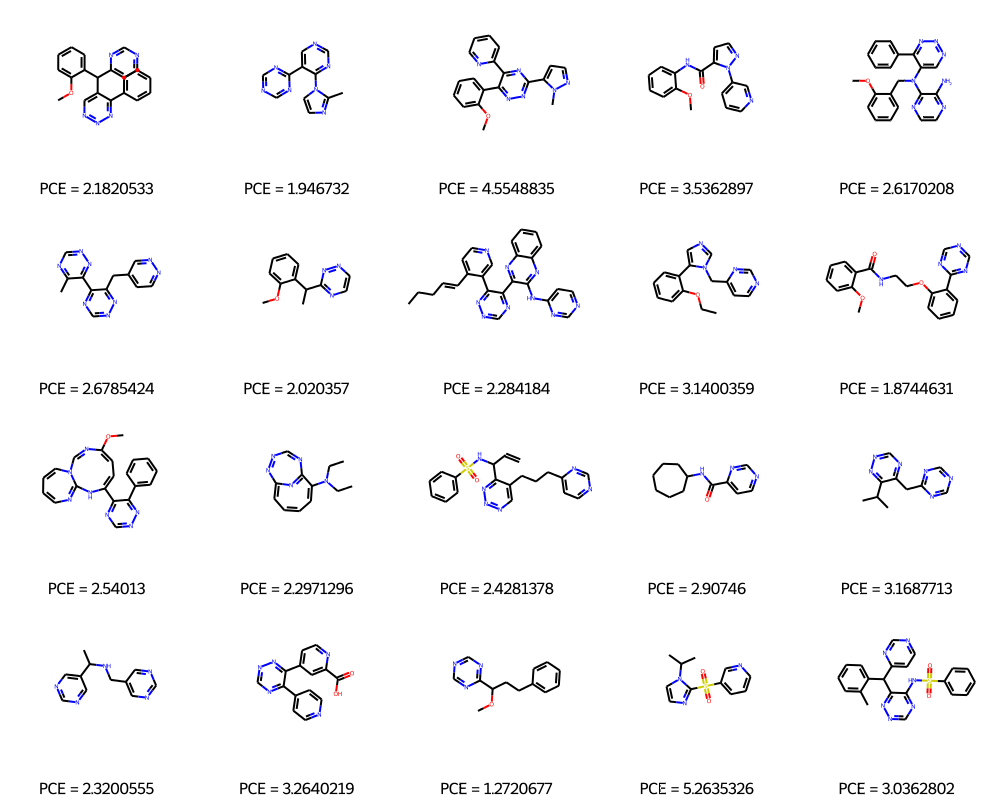

In [88]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['PCE = ' + str(prediction_biased[i]) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)